In [36]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import os

# DDoS attacks:
A distributed denial-of-service (DDoS) attack is a malicious attempt to disrupt the normal traffic of a targeted server, service or network by overwhelming the target or its surrounding infrastructure with a flood of Internet traffic.

DDoS attacks achieve effectiveness by utilizing multiple compromised computer systems as sources of attack traffic. Exploited machines can include computers and other networked resources such as IoT devices.

From a high level, a DDoS attack is like an unexpected traffic jam clogging up the highway, preventing regular traffic from arriving at its destination.
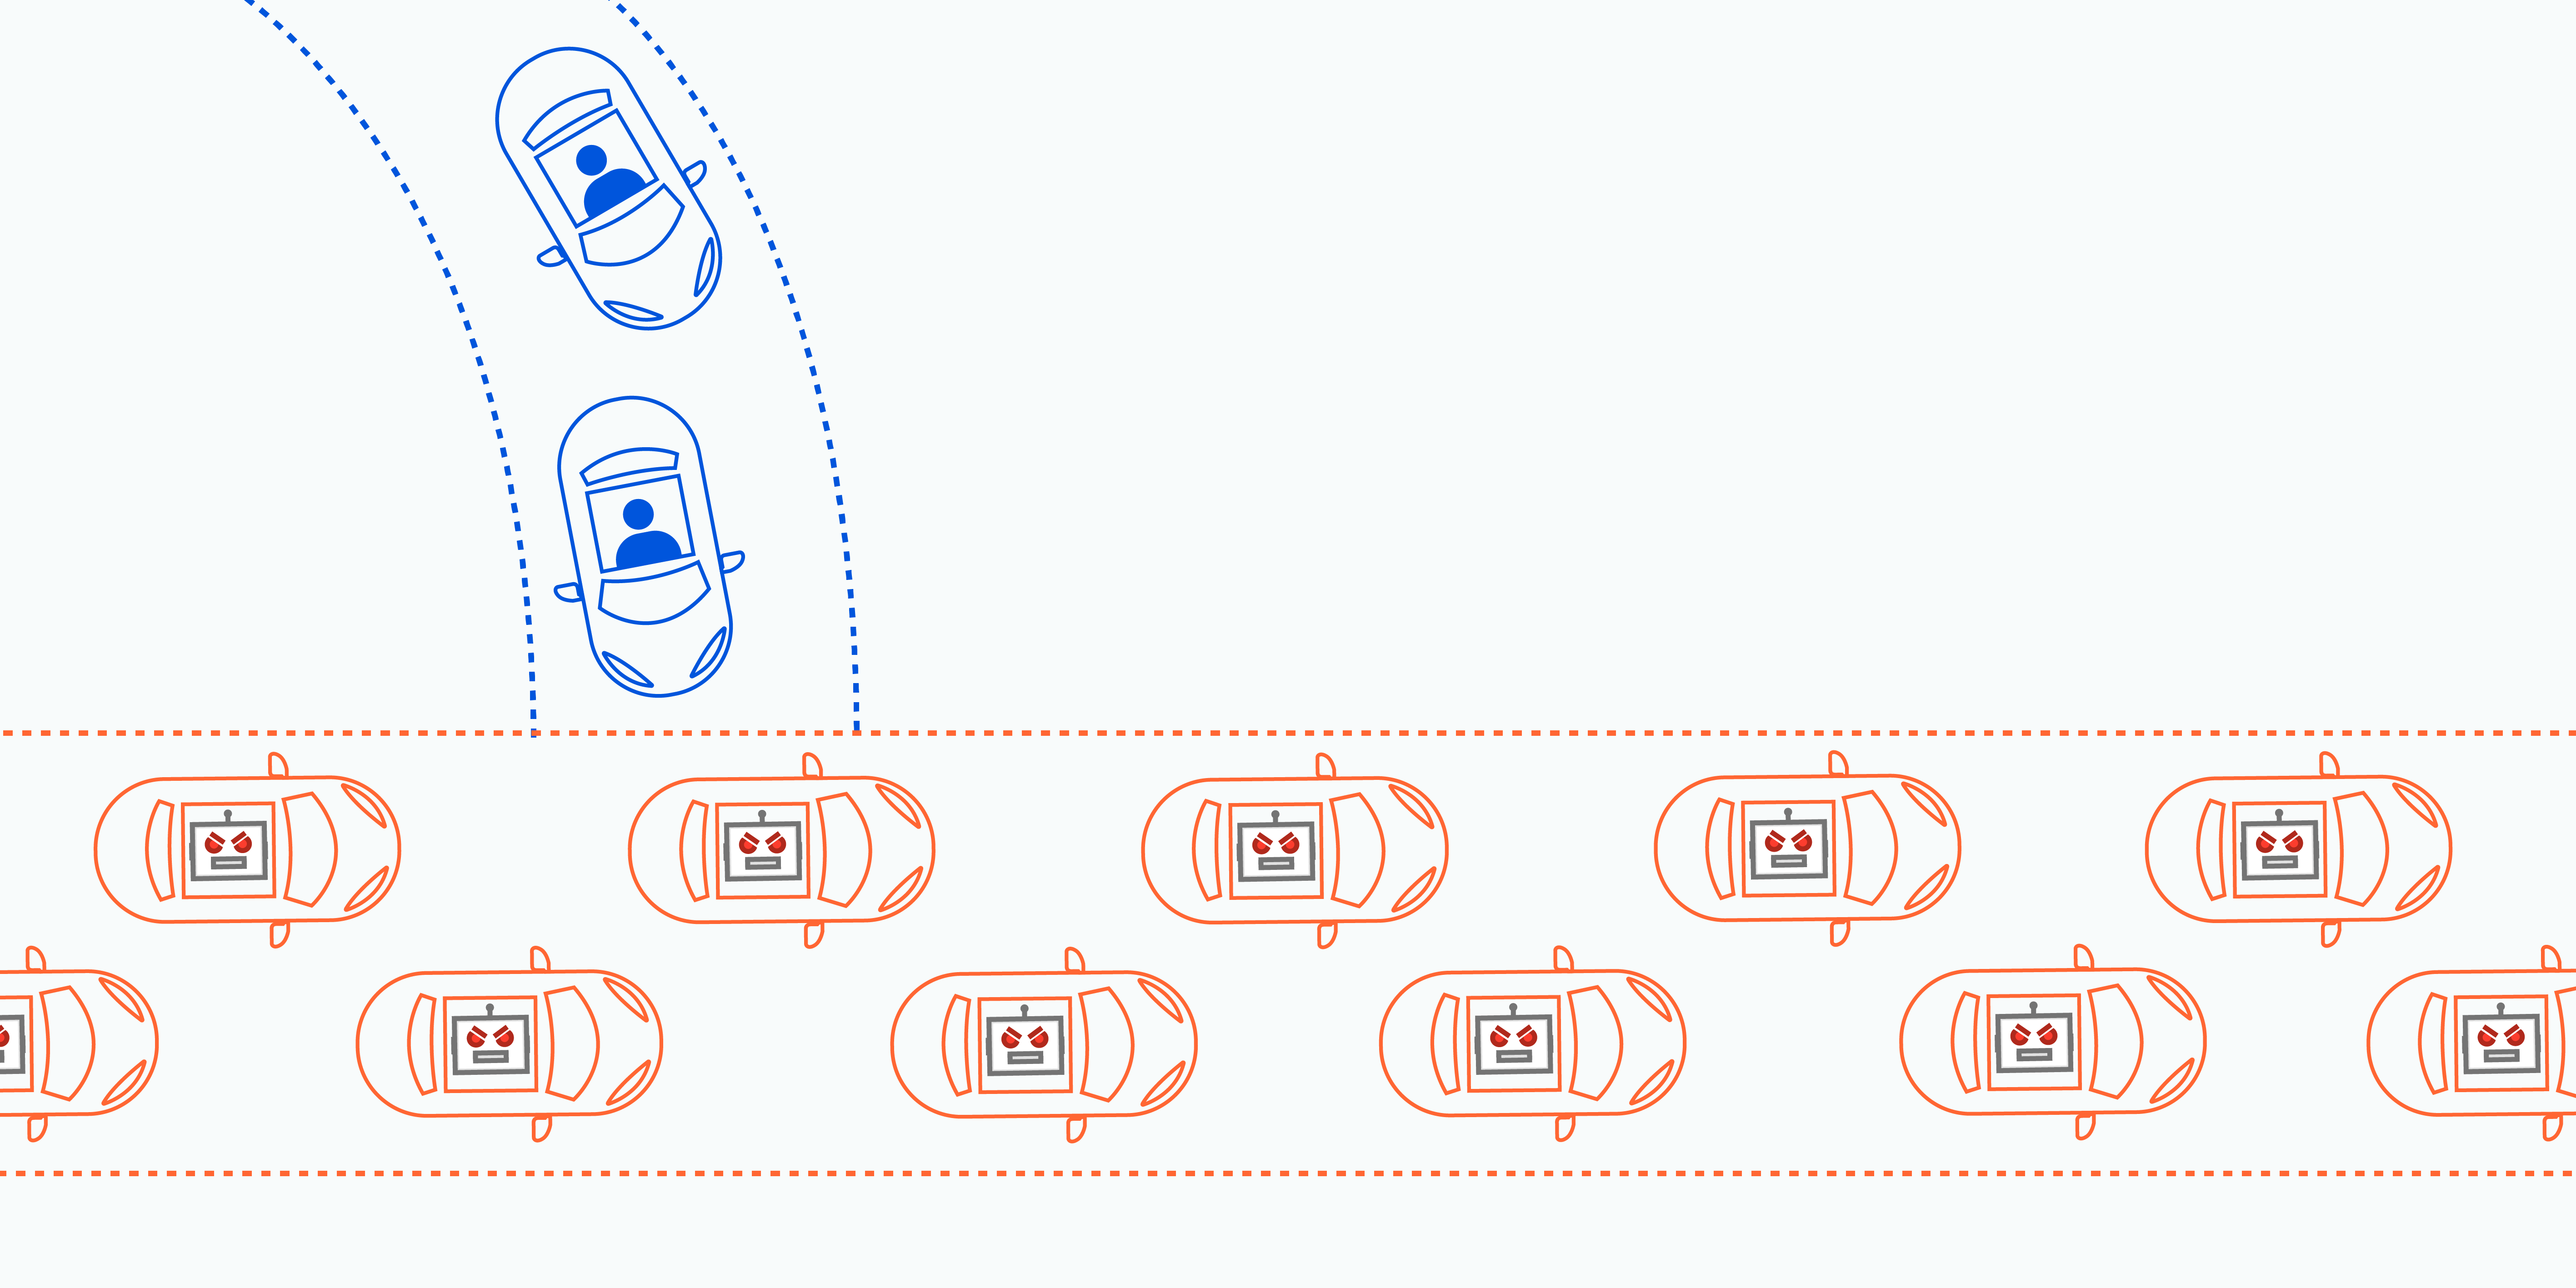

# How to identify a DDoS attack:
The most obvious symptom of a DDoS attack is a site or service suddenly becoming slow or unavailable. But since a number of causes — such a legitimate spike in traffic — can create similar performance issues, further investigation is usually required. Traffic analytics tools can help you spot some of these telltale signs of a DDoS attack:

* Suspicious amounts of traffic originating from a single IP address or IP range 
* A flood of traffic from users who share a single behavioral profile, such as device type, geolocation, or web browser version
* An unexplained surge in requests to a single page or endpoint
* Odd traffic patterns such as spikes at odd hours of the day or patterns that appear to be unnatural (e.g. a spike every 10 minutes)

**There are other, more specific signs of DDoS attack that can vary depending on the type of attack.**

**The objectif:** Utilize LSTM-based time series modeling to predict DDoS attacks with the aim of enhancing early detection and proactive mitigation strategies.

# Imporing the dataset:

In [37]:
#Importing dataset
ddos_data=pd.read_csv('C:/Users/NGESSI/Documents/DDoS Prediction/v2/dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
train_columns=ddos_data.columns.tolist()
ddos_data.shape

(225745, 85)

This dataset contains **225745** instances, and **85** columns.

In [38]:
ddos_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225745 entries, 0 to 225744
Data columns (total 85 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Flow ID                       225745 non-null  object 
 1    Source IP                    225745 non-null  object 
 2    Source Port                  225745 non-null  int64  
 3    Destination IP               225745 non-null  object 
 4    Destination Port             225745 non-null  int64  
 5    Protocol                     225745 non-null  int64  
 6    Timestamp                    225745 non-null  object 
 7    Flow Duration                225745 non-null  int64  
 8    Total Fwd Packets            225745 non-null  int64  
 9    Total Backward Packets       225745 non-null  int64  
 10  Total Length of Fwd Packets   225745 non-null  int64  
 11   Total Length of Bwd Packets  225745 non-null  int64  
 12   Fwd Packet Length Max        225745 non-nul

In [39]:
ddos_data.describe()

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,225745.000000,225745.00000,225745.000000,2.257450e+05,225745.000000,225745.000000,225745.000000,2.257450e+05,225745.000000,225745.000000,...,225745.000000,225745.000000,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05
mean,38257.568402,8879.61946,7.600288,1.624165e+07,4.874916,4.572775,939.463346,5.960477e+03,538.535693,27.882221,...,3.311497,21.482753,1.848261e+05,1.293436e+04,2.080849e+05,1.776201e+05,1.032214e+07,3.611943e+06,1.287813e+07,7.755355e+06
std,23057.302075,19754.64740,3.881586,3.152437e+07,15.422874,21.755356,3249.403484,3.921834e+04,1864.128991,163.324159,...,12.270018,4.166799,7.979250e+05,2.102737e+05,9.002350e+05,7.842602e+05,2.185303e+07,1.275689e+07,2.692126e+07,1.983109e+07
min,0.000000,0.00000,0.000000,-1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,18990.000000,80.00000,6.000000,7.118000e+04,2.000000,1.000000,26.000000,0.000000e+00,6.000000,0.000000,...,1.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,49799.000000,80.00000,6.000000,1.452333e+06,3.000000,4.000000,30.000000,1.640000e+02,20.000000,0.000000,...,2.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,58296.000000,80.00000,6.000000,8.805237e+06,5.000000,5.000000,63.000000,1.160100e+04,34.000000,6.000000,...,4.000000,20.000000,1.878000e+03,0.000000e+00,1.878000e+03,1.862000e+03,8.239725e+06,0.000000e+00,8.253838e+06,7.422849e+06
max,65534.000000,65532.00000,17.000000,1.199999e+08,1932.000000,2942.000000,183012.000000,5.172346e+06,11680.000000,1472.000000,...,1931.000000,52.000000,1.000000e+08,3.950000e+07,1.000000e+08,1.000000e+08,1.200000e+08,6.530000e+07,1.200000e+08,1.200000e+08


In [40]:
ddos_data.isnull().sum()

Flow ID              0
 Source IP           0
 Source Port         0
 Destination IP      0
 Destination Port    0
                    ..
Idle Mean            0
 Idle Std            0
 Idle Max            0
 Idle Min            0
 Label               0
Length: 85, dtype: int64

# Getting an overview of different features:

## Distribution of `Label` column:

In [41]:
ddos_data[' Label'].value_counts()

DDoS      128027
BENIGN     97718
Name:  Label, dtype: int64

In [42]:
def visualize_labels_distribution(ddos_data):
    label_counts=ddos_data[' Label'].value_counts()
    plt.figure(figsize=(3, 3))
    plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Distribution of DDoS Attack Types')
    plt.axis('equal') 
    plt.show()

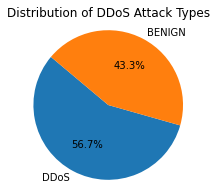

In [43]:
visualize_labels_distribution(ddos_data)

The distribution of labels in the dataset reflects a well-balanced representation of the two classes, with approximately **43.3%** classified as **benign** and **56.7%** as **DDoS attacks**, indicating a **balanced dataset composition.**

## Normalizing ` Timestamp` column:
We need to normalize the `Timestamp` column to facilitate the examination of how various features evolve over time.

In [44]:
def normalize_timestamp(ddos_data):
    ddos_data[' Timestamp'] = pd.to_datetime(ddos_data[' Timestamp'])
    ddos_data.sort_values(by=' Timestamp', inplace=True)

In [45]:
normalize_timestamp(ddos_data)

## Visualize different features' variation in time:

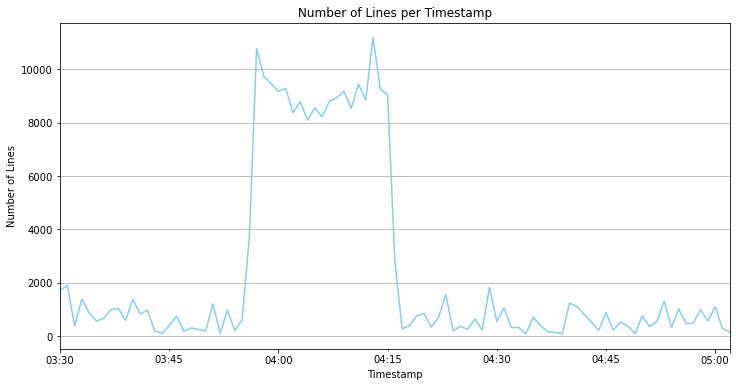

In [46]:
connection_grouped_by_time=ddos_data.groupby(' Timestamp').size()
plt.figure(figsize=(12, 6))
connection_grouped_by_time.plot(kind='line', color='skyblue')
plt.xlabel('Timestamp')
plt.ylabel('Number of Lines')
#plt.xticks(rotation=90)
plt.title('Number of Lines per Timestamp')
plt.grid(axis='y')
plt.show()

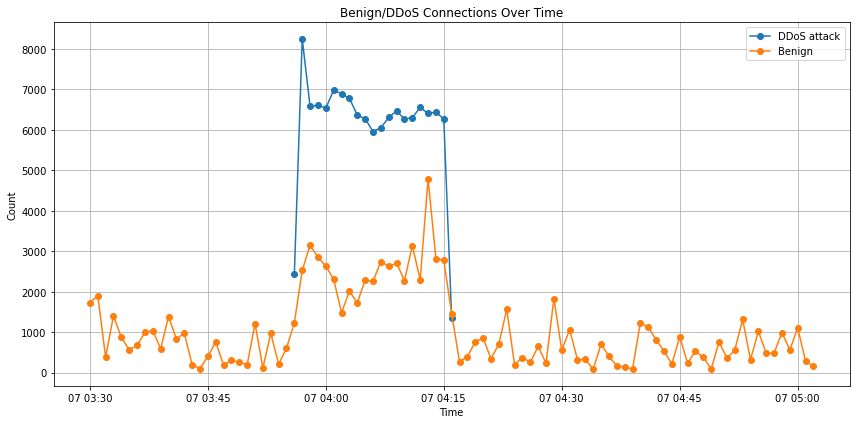

In [47]:
connection_by_time_b=ddos_data[ddos_data[' Label']=='BENIGN'].groupby(' Timestamp').size()
connection_by_time_nb=ddos_data[ddos_data[' Label']!='BENIGN'].groupby(' Timestamp').size()
plt.figure(figsize=(12, 6))
plt.plot(connection_by_time_nb.index, connection_by_time_nb.values, marker='o', linestyle='-',label='DDoS attack')
plt.plot(connection_by_time_b.index, connection_by_time_b.values, marker='o', linestyle='-', label='Benign')
plt.title('Benign/DDoS Connections Over Time')
plt.xlabel('Time')
plt.ylabel('Count')
#plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

Although this dataset contains more connections associated with DDoS attacks, the connections labeled as benign are more evenly distributed over time. Conversely, connections labeled as DDoS attacks are concentrated within a short time interval, with a high number of requests. Additionally, within this time interval, the number of connections labeled as benign is also relatively high.

**DDoS attacks are often characterized by a large number of requests sent simultaneously or over a very short period of time.**

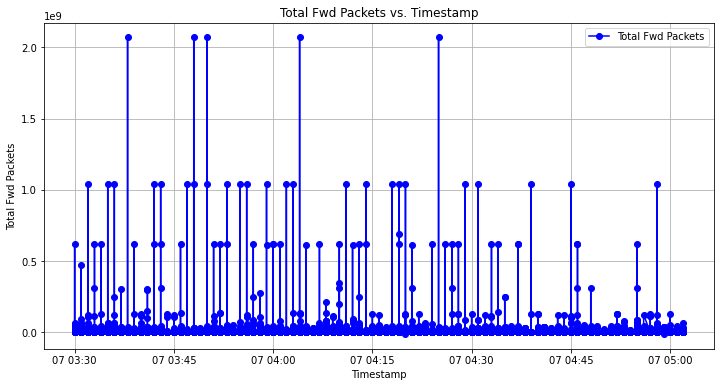

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(ddos_data[' Timestamp'], ddos_data['Flow Bytes/s'], color='blue', marker='o', linestyle='-', label='Total Fwd Packets')
plt.title('Total Fwd Packets vs. Timestamp')
plt.xlabel('Timestamp')
plt.ylabel('Total Fwd Packets')
plt.legend()
plt.grid(True)
plt.show()

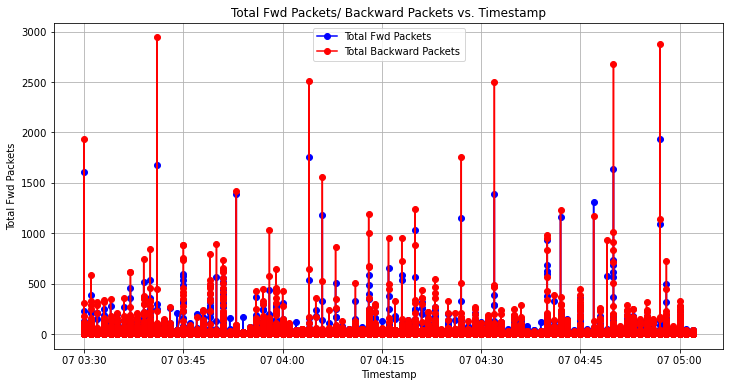

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(ddos_data[' Timestamp'], ddos_data[' Total Fwd Packets'], color='blue', marker='o', linestyle='-', label='Total Fwd Packets')
plt.plot(ddos_data[' Timestamp'], ddos_data[' Total Backward Packets'], color='red', marker='o', linestyle='-', label='Total Backward Packets')
plt.title('Total Fwd Packets/ Backward Packets vs. Timestamp')
plt.xlabel('Timestamp')
plt.ylabel('Total Fwd Packets')
plt.legend()
plt.grid(True)
plt.show()

## Distribution and visualisation of different features:

In [50]:
categorical_features = [col for col in ddos_data.columns if ddos_data[col].dtype == 'object']
categorical_features

['Flow ID', ' Source IP', ' Destination IP', ' Label']

In [51]:
binary_columns=ddos_data.columns[ddos_data.nunique()==2].tolist()
binary_columns

['Fwd PSH Flags',
 'FIN Flag Count',
 ' SYN Flag Count',
 ' RST Flag Count',
 ' PSH Flag Count',
 ' ACK Flag Count',
 ' URG Flag Count',
 ' ECE Flag Count',
 ' Label']

**Fwd PSH Flags:** PSH (Push) flags in TCP packets indicate that the data should be pushed immediately to the receiving application rather than waiting in the buffer. This flag is set in the forward direction (from sender to receiver) in a TCP connection.

**FIN Flag Count:** FIN (Finish) flags in TCP packets indicate the intention to close the connection. When a party sends a FIN flag, it means it has finished sending data and wants to close the connection. This column likely represents the count of FIN flags observed in the network traffic.

**SYN Flag Count:** SYN (Synchronize) flags in TCP packets are used to initiate a connection between two devices. When a device wants to start a TCP connection with another device, it sends a packet with the SYN flag set. This column represents the count of SYN flags observed in the network traffic.

**RST Flag Count:** RST (Reset) flags in TCP packets indicate the abrupt termination of a connection. It can be used to reset a connection that is in a bad state or to indicate refusal to accept a connection request. This column represents the count of RST flags observed in the network traffic.

**PSH Flag Count:** PSH (Push) flags in TCP packets, as mentioned earlier, indicate that the data should be pushed immediately to the receiving application. This column represents the count of PSH flags observed in the network traffic.

**ACK Flag Count:** ACK (Acknowledgment) flags in TCP packets are used to acknowledge the receipt of data packets. When a device receives data packets from another device, it sends acknowledgment packets with the ACK flag set. This column represents the count of ACK flags observed in the network traffic.

**URG Flag Count:** URG (Urgent) flags in TCP packets indicate that the data contained in the packet is urgent and should be processed immediately. This column represents the count of URG flags observed in the network traffic.

**ECE Flag Count:** ECE (Explicit Congestion Notification Echo) flags in TCP packets are used for congestion control in the network. They indicate that the sender received a congestion indication and should reduce its transmission rate. This column represents the count of ECE flags observed in the network traffic.

### Distribtuion of binary features by ` Label`:

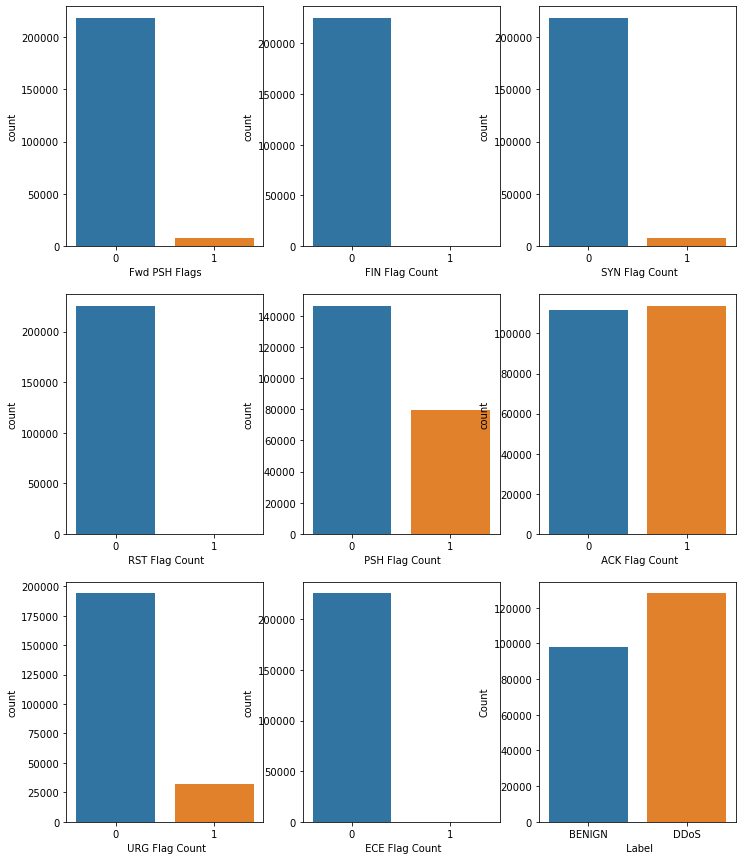

In [52]:
fig, ax = plt.subplots(3, 3, figsize=(12, 15))
ax = ax.flatten()
for i, column in enumerate(binary_columns):
    sns.countplot(data=ddos_data, x=column, ax=ax[i])
    #plt.title(f'Distribution of {column} by Label')
    plt.xlabel(column)
    plt.ylabel('Count')
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


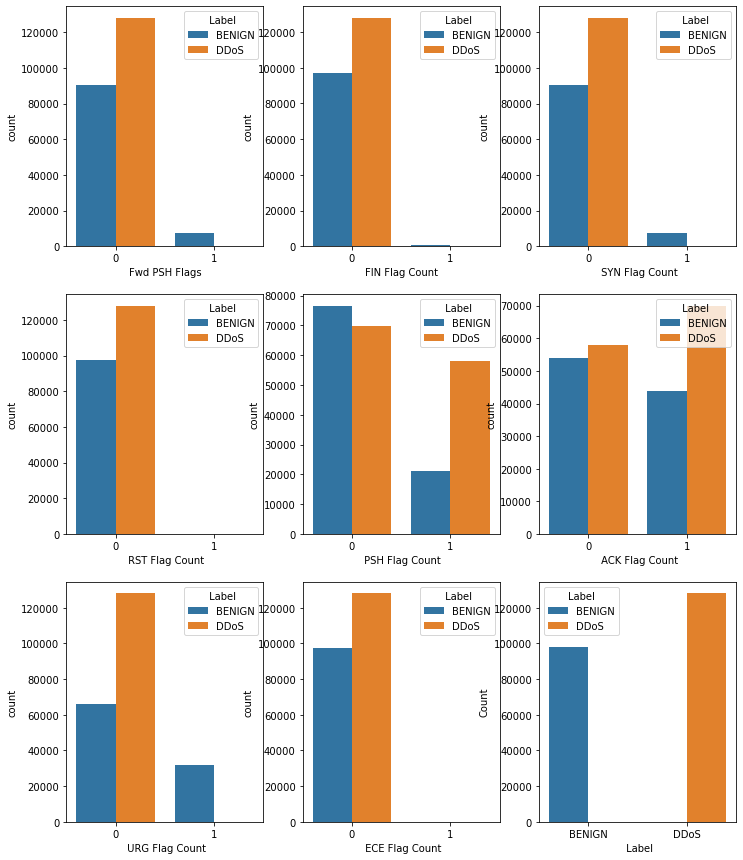

In [53]:
fig, ax = plt.subplots(3, 3, figsize=(12, 15))
ax = ax.flatten()
for i, column in enumerate(binary_columns):
    sns.countplot(data=ddos_data, x=column, hue=' Label',ax=ax[i])
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.legend(title='Label')
plt.show()

In [54]:
ddos_data.nunique()

Flow ID              86421
 Source IP            2067
 Source Port         50697
 Destination IP       2554
 Destination Port    23950
                     ...  
Idle Mean            35285
 Idle Std             5857
 Idle Max            33002
 Idle Min            48018
 Label                   2
Length: 85, dtype: int64

We have many ` Source IP`, ` Destination IP` adresses, So it won't be easy to visualize their request of connections by time.

### Distribution of `Protocol`:

In [55]:
ddos_data[' Protocol'].value_counts()

6     192820
17     32871
0         54
Name:  Protocol, dtype: int64

6: TCP
17: UDP
0: HOPOPT

Source: https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml

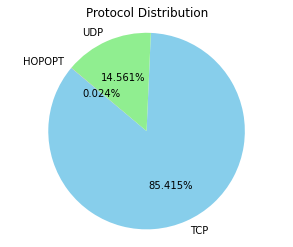

In [56]:
protocol_counts=ddos_data[' Protocol'].value_counts()
protocol_names={
    6: 'TCP', 17: 'UDP', 0: 'HOPOPT'
}
protocol_counts.index = protocol_counts.index.map(protocol_names)
plt.figure(figsize=(5, 4))
protocol_counts.plot(kind='pie', autopct='%1.3f%%', startangle=140, colors=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Protocol Distribution')
plt.ylabel('')
plt.axis('equal')
plt.show()

### Distribution of `Protocol` by Label:

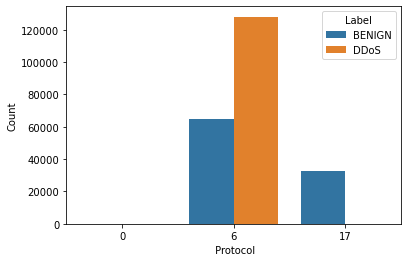

In [57]:
sns.countplot(data=ddos_data, x=' Protocol', hue=' Label')
plt.xlabel(' Protocol')
plt.ylabel('Count')
plt.legend(title='Label')

### Discrete non-binary variables and continous variables:

In [58]:
discrete_vars_non_binary = [col for col in ddos_data.columns if ddos_data[col].dtype == 'int64' and col not in binary_columns]
continuous_vars = [col for col in ddos_data.columns if ddos_data[col].dtype == 'float64']

In [59]:
def viz_variable(variable):
    non_benign_data = ddos_data[ddos_data[' Label'] != 'BENIGN']
    non_benign_bytes_by_time = non_benign_data.groupby([' Timestamp', variable]).size().reset_index(name='count')
    non_benign_bytes_by_time = non_benign_bytes_by_time.groupby(' Timestamp')[variable].mean()

    benign_data = ddos_data[ddos_data[' Label'] == 'BENIGN']

    benign_bytes_by_time =benign_data.groupby([' Timestamp', variable]).size().reset_index(name='count')
    benign_bytes_by_time = benign_bytes_by_time.groupby(' Timestamp')[variable].mean()

    plt.figure(figsize=(12, 6))
    plt.plot(non_benign_bytes_by_time.index, non_benign_bytes_by_time.values, label='Non-Benign', linestyle='-', marker='o')
    plt.plot(benign_bytes_by_time.index, benign_bytes_by_time.values, label='Benign', linestyle='-', marker='o')
    plt.title('Average '+variable+ ' Received Over Time for non benign connections')
    plt.xlabel('Time')
    plt.ylabel('Average Bytes')
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [60]:
discrete_vars_non_binary

[' Source Port',
 ' Destination Port',
 ' Protocol',
 ' Flow Duration',
 ' Total Fwd Packets',
 ' Total Backward Packets',
 'Total Length of Fwd Packets',
 ' Total Length of Bwd Packets',
 ' Fwd Packet Length Max',
 ' Fwd Packet Length Min',
 'Bwd Packet Length Max',
 ' Bwd Packet Length Min',
 ' Flow IAT Max',
 ' Flow IAT Min',
 'Fwd IAT Total',
 ' Fwd IAT Max',
 ' Fwd IAT Min',
 'Bwd IAT Total',
 ' Bwd IAT Max',
 ' Bwd IAT Min',
 ' Bwd PSH Flags',
 ' Fwd URG Flags',
 ' Bwd URG Flags',
 ' Fwd Header Length',
 ' Bwd Header Length',
 ' Min Packet Length',
 ' Max Packet Length',
 ' CWE Flag Count',
 ' Down/Up Ratio',
 ' Fwd Header Length.1',
 'Fwd Avg Bytes/Bulk',
 ' Fwd Avg Packets/Bulk',
 ' Fwd Avg Bulk Rate',
 ' Bwd Avg Bytes/Bulk',
 ' Bwd Avg Packets/Bulk',
 'Bwd Avg Bulk Rate',
 'Subflow Fwd Packets',
 ' Subflow Fwd Bytes',
 ' Subflow Bwd Packets',
 ' Subflow Bwd Bytes',
 'Init_Win_bytes_forward',
 ' Init_Win_bytes_backward',
 ' act_data_pkt_fwd',
 ' min_seg_size_forward',
 ' Active

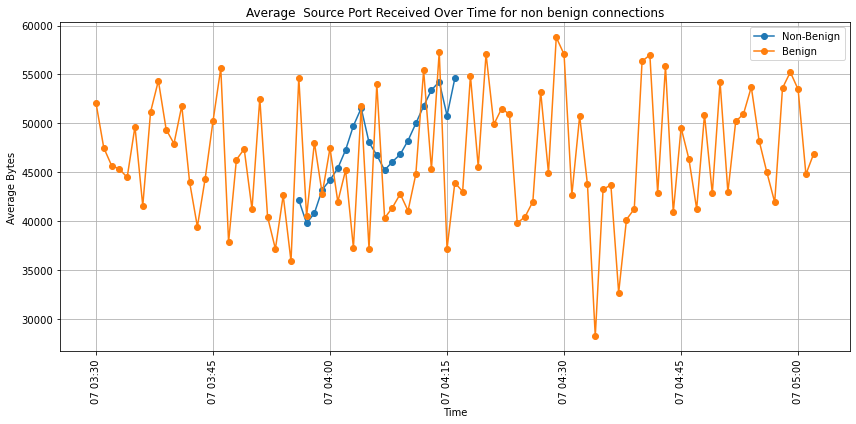

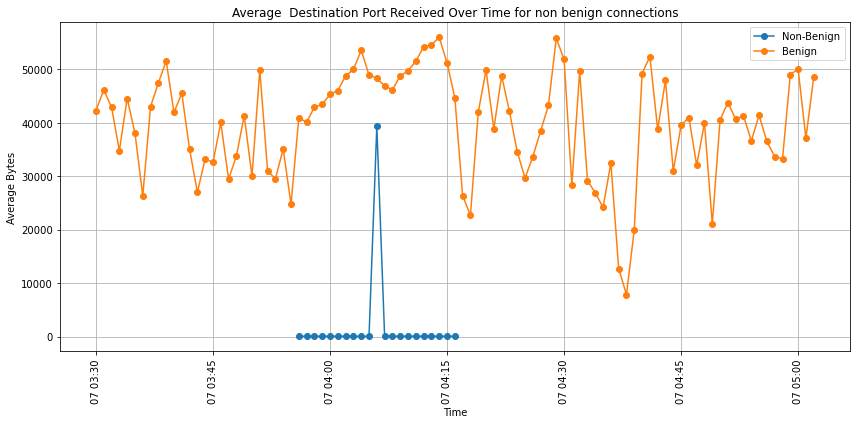

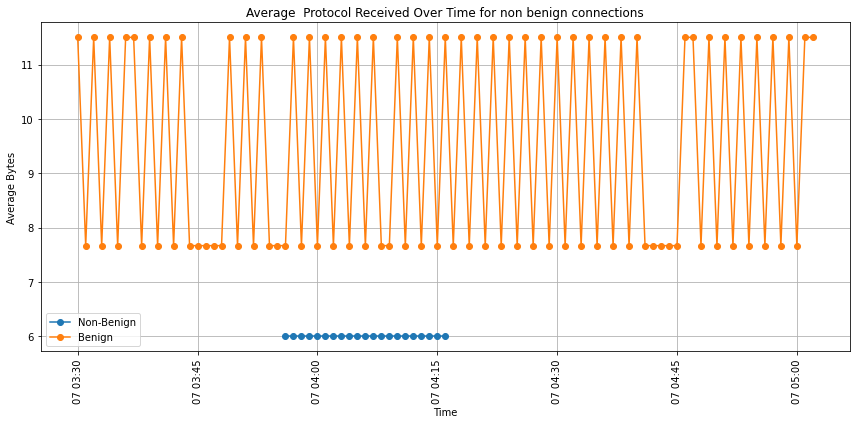

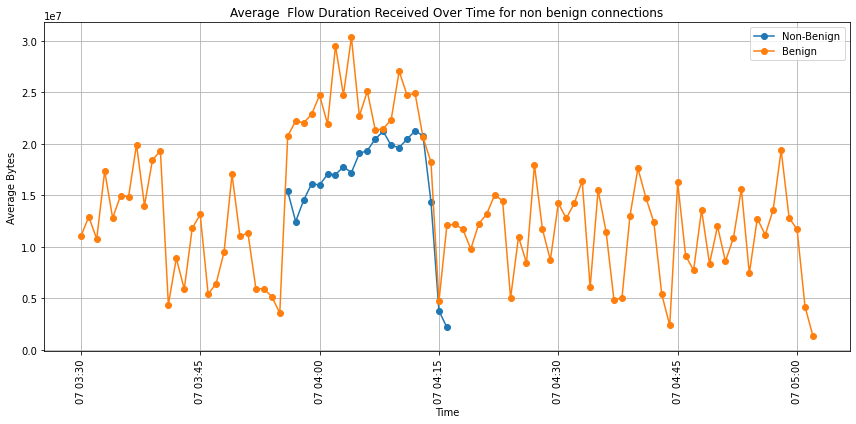

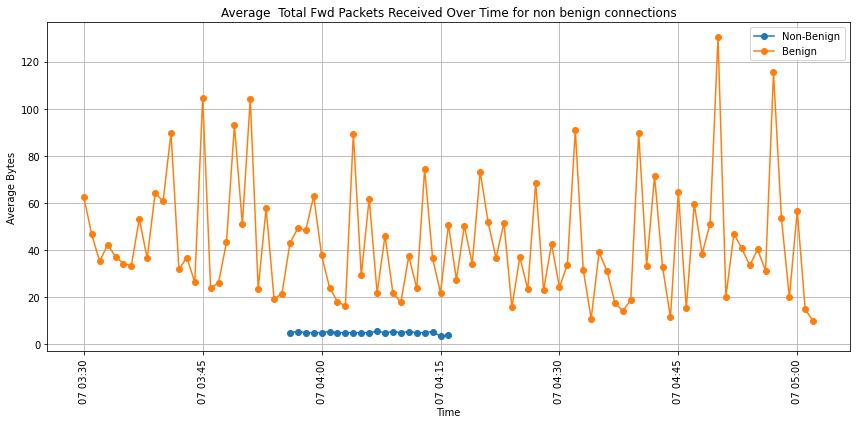

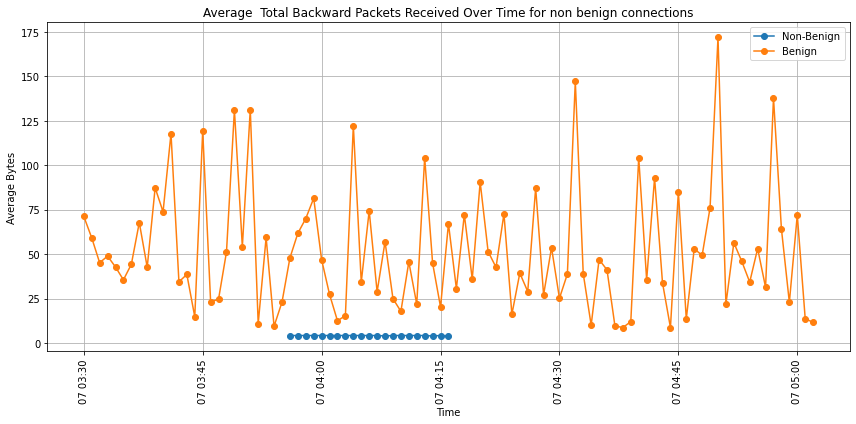

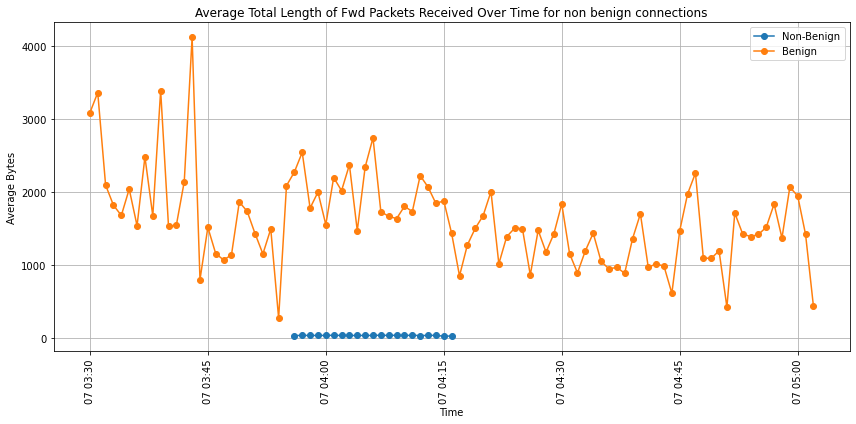

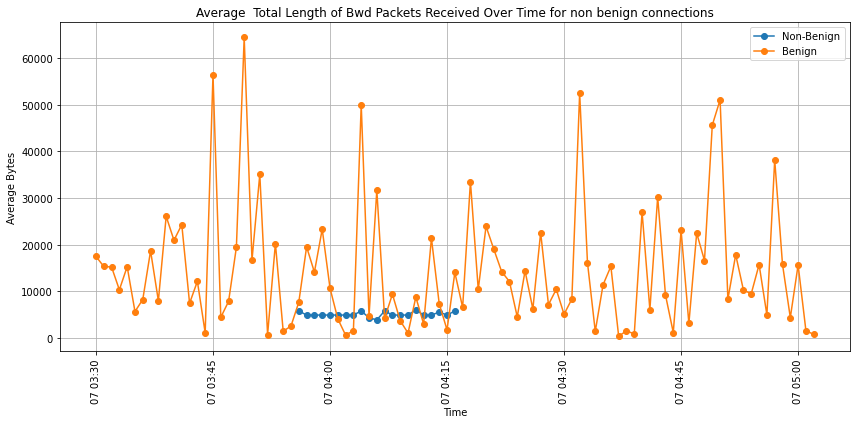

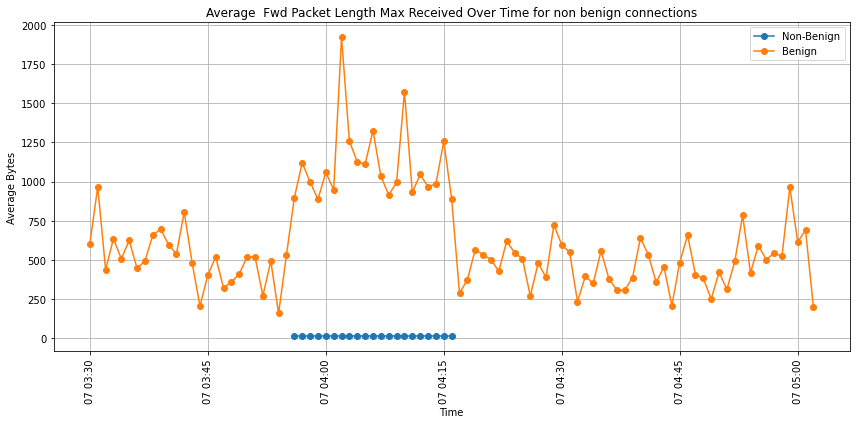

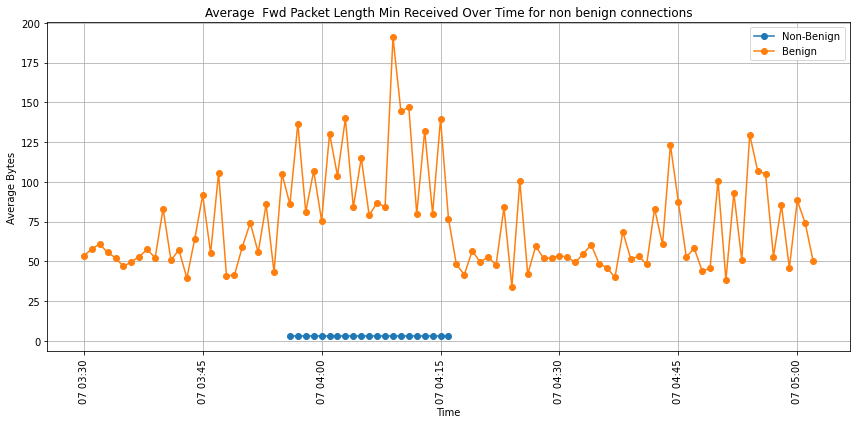

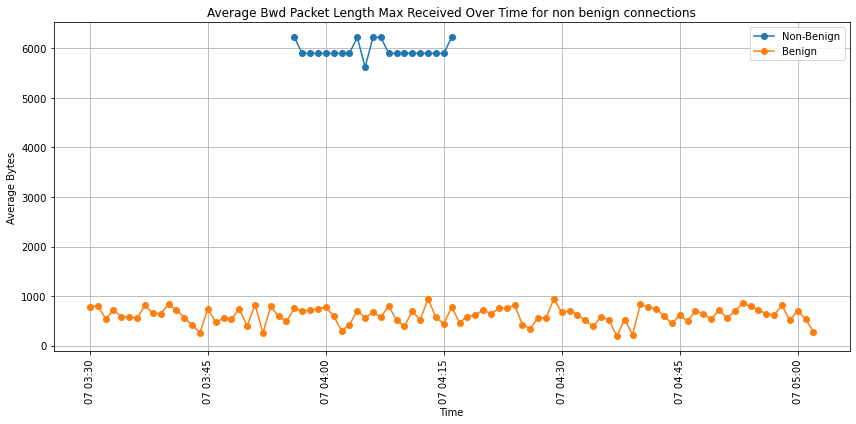

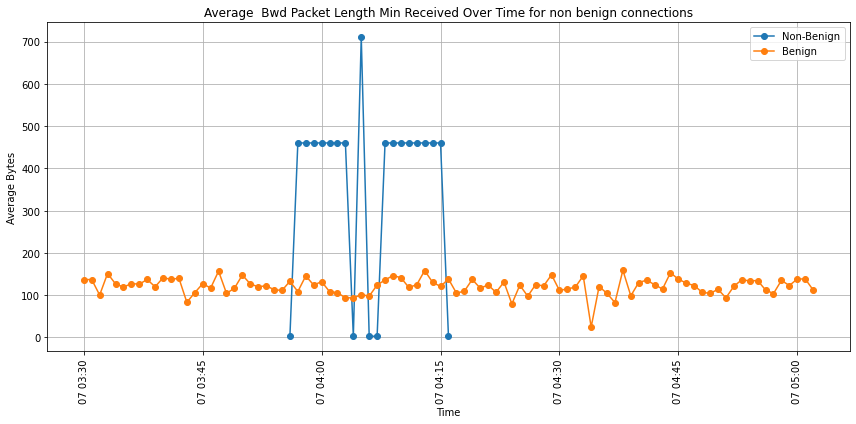

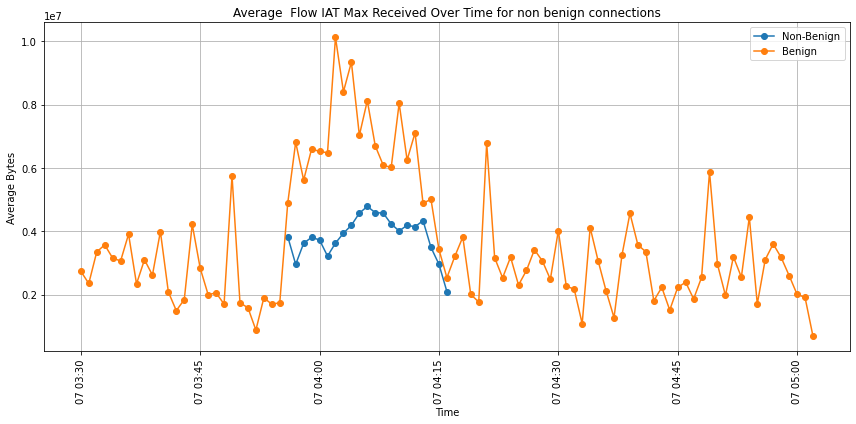

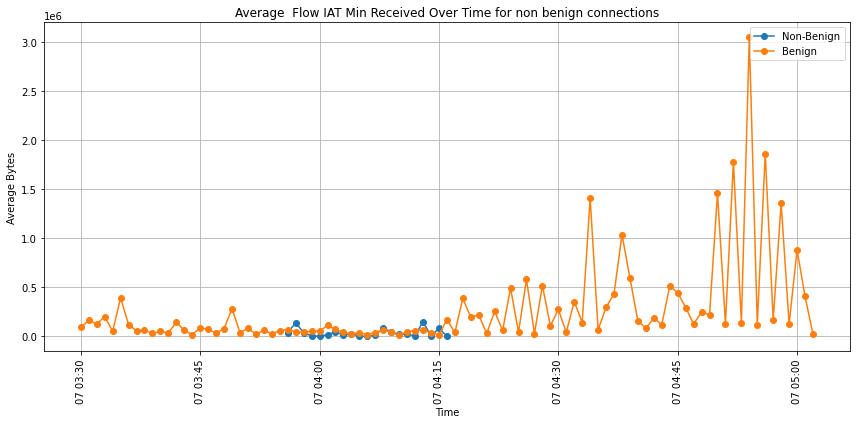

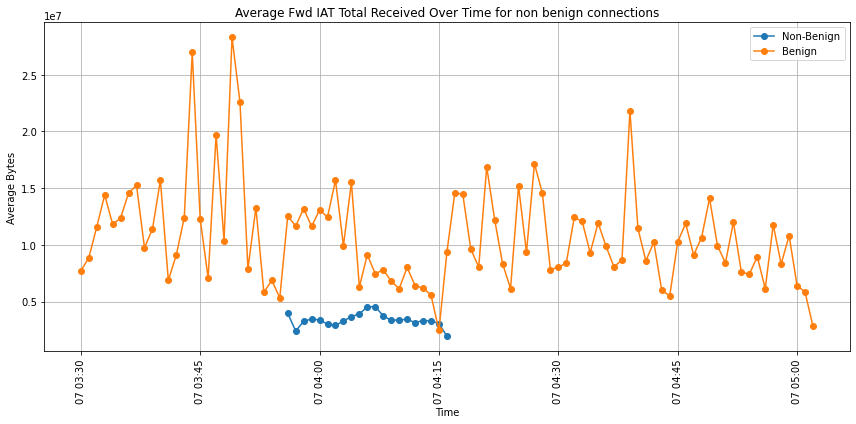

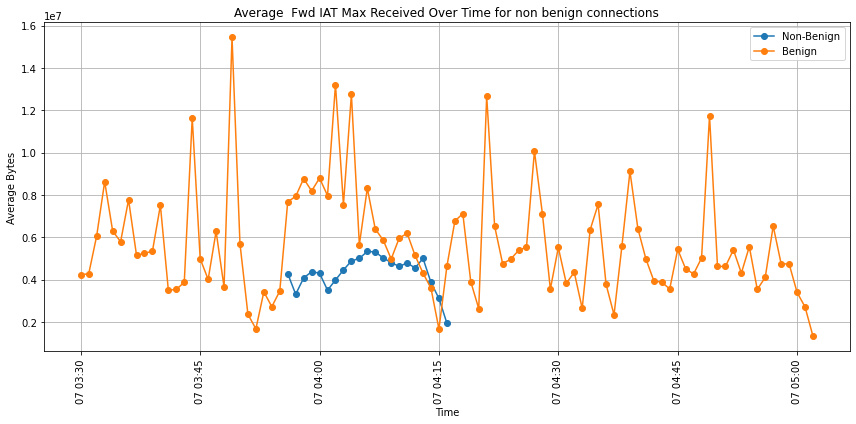

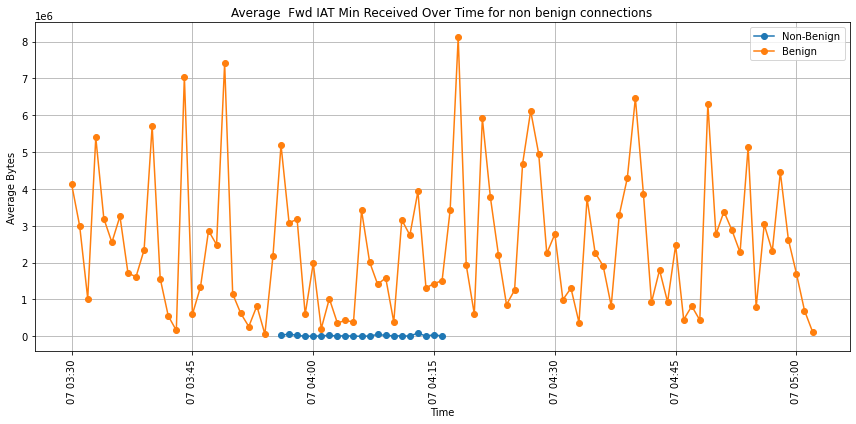

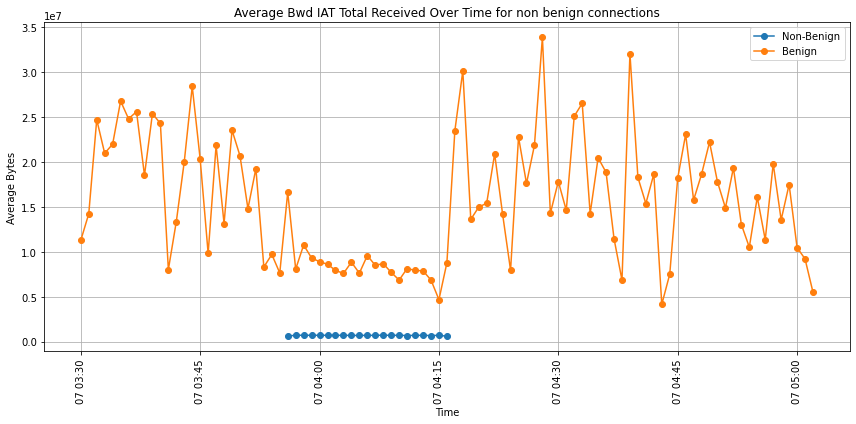

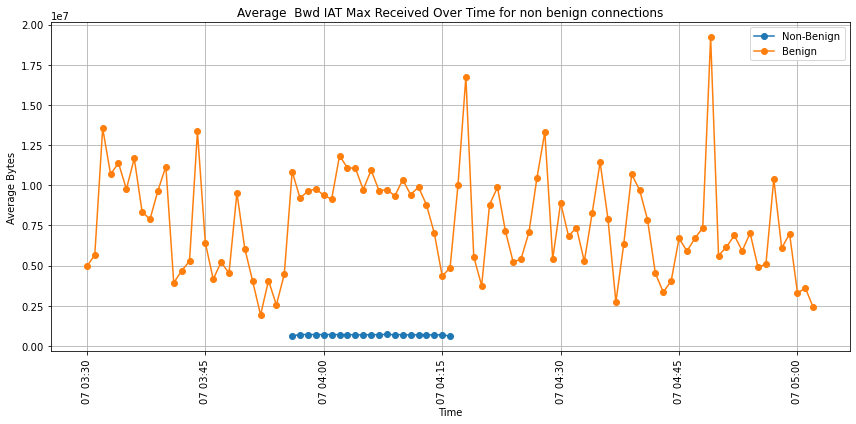

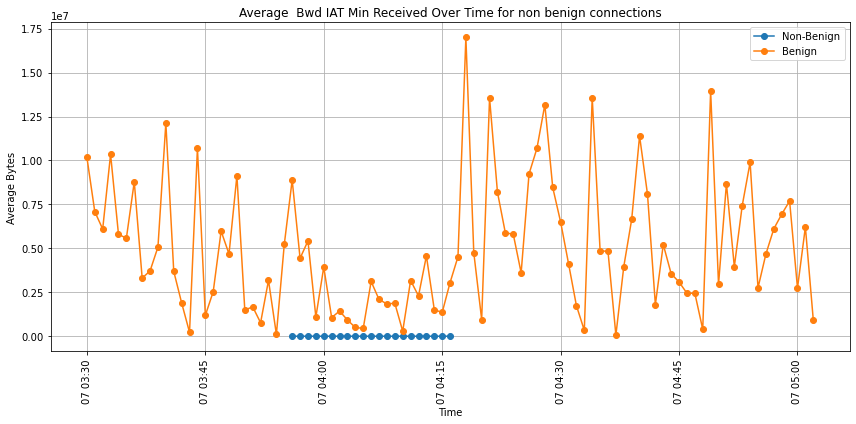

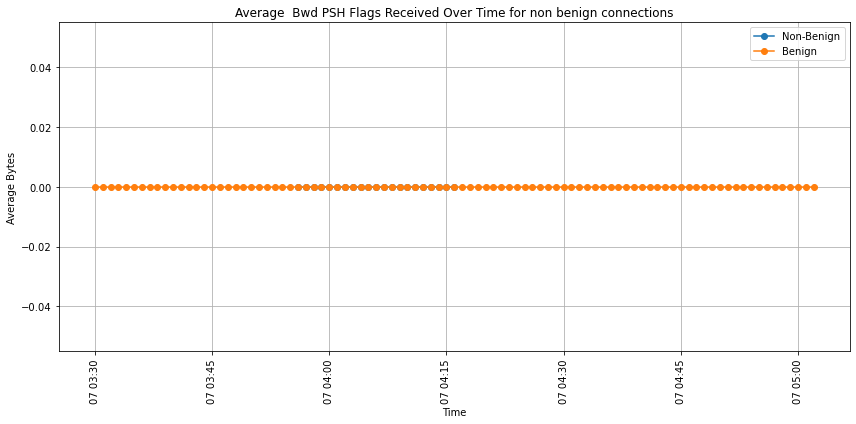

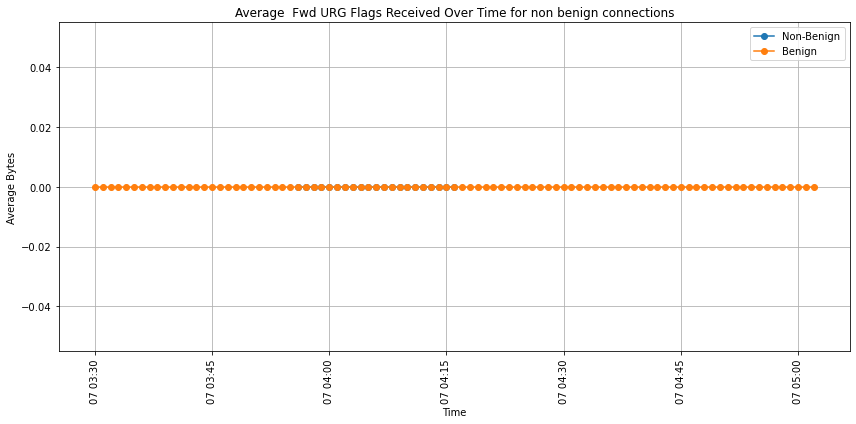

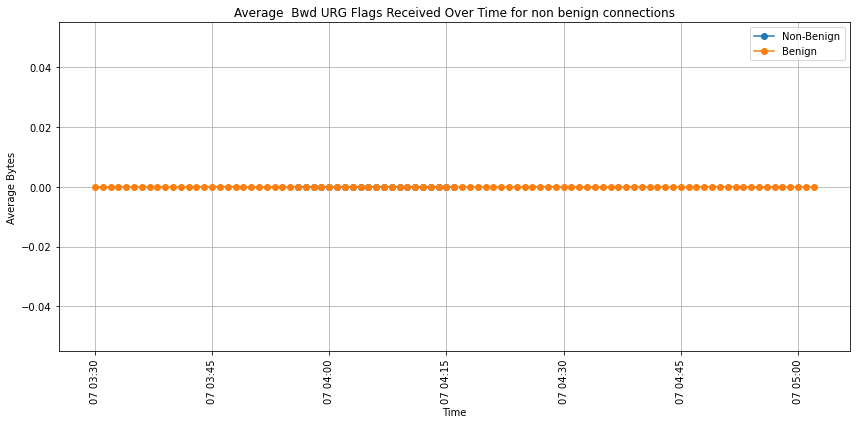

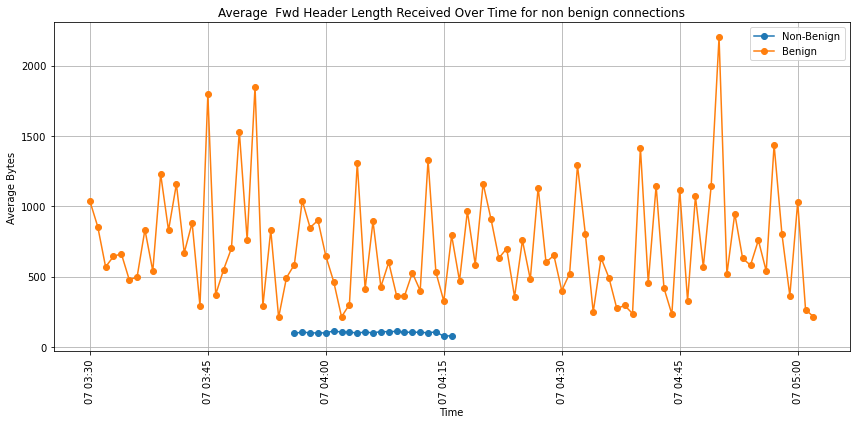

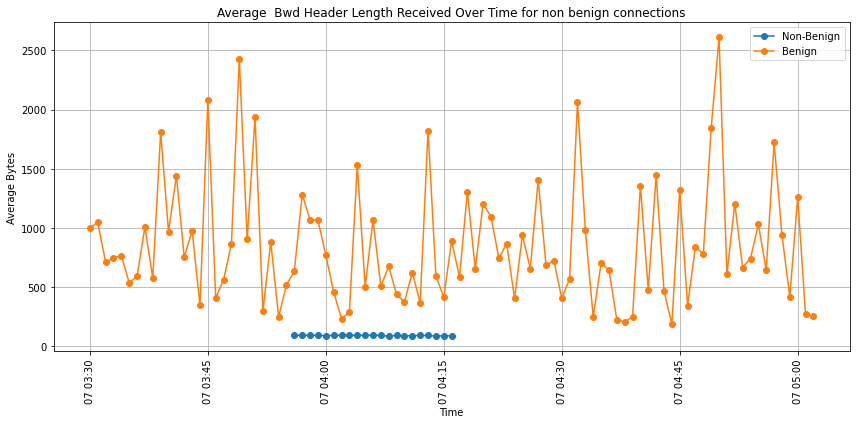

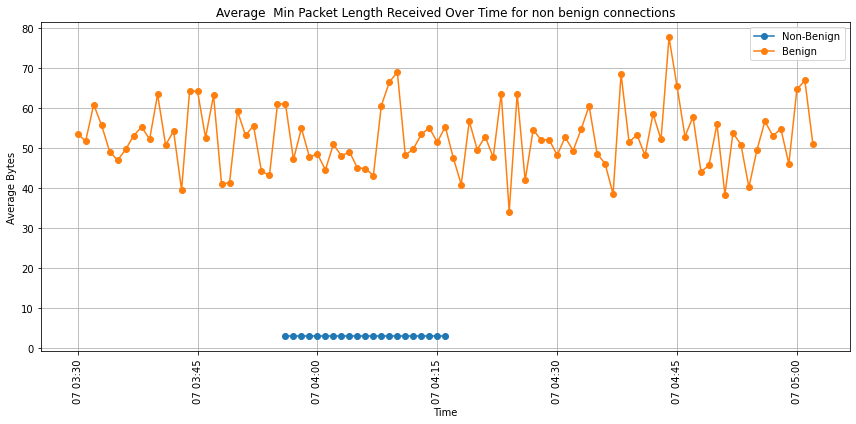

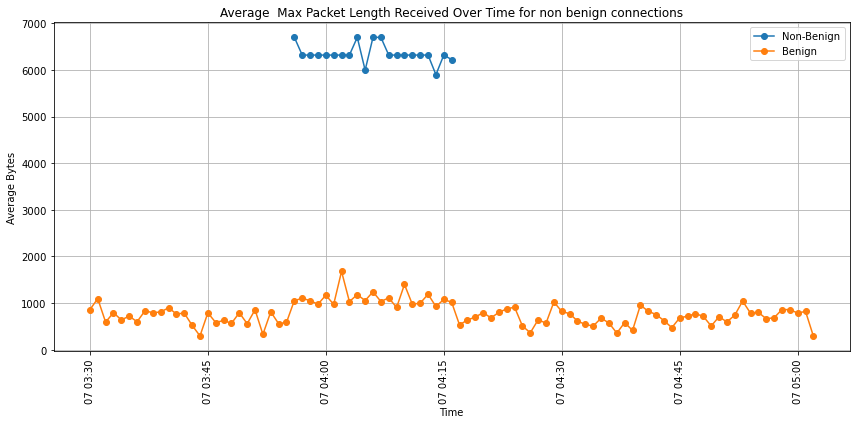

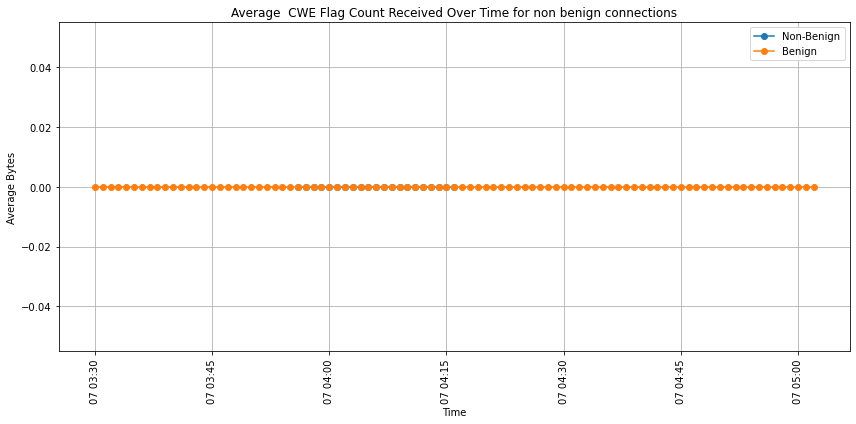

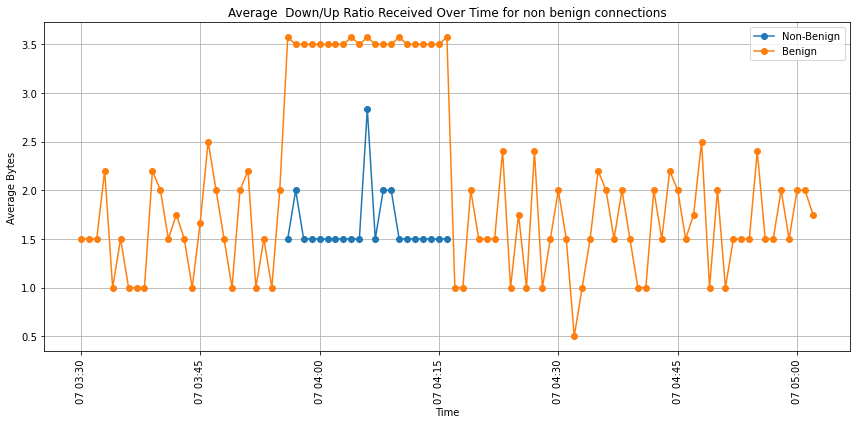

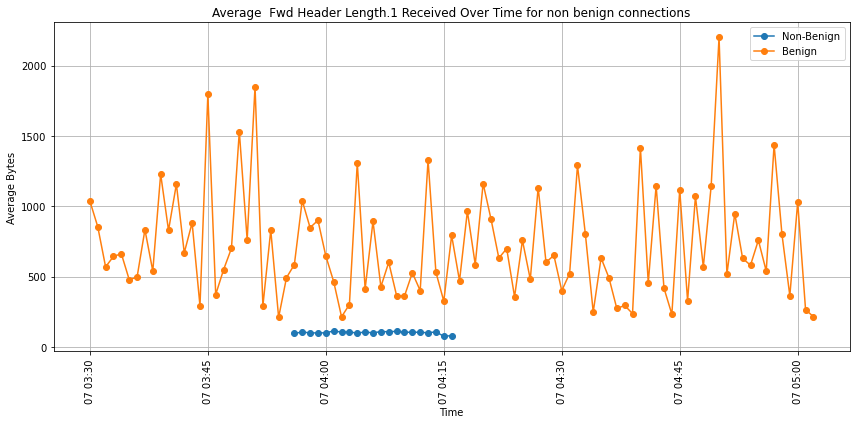

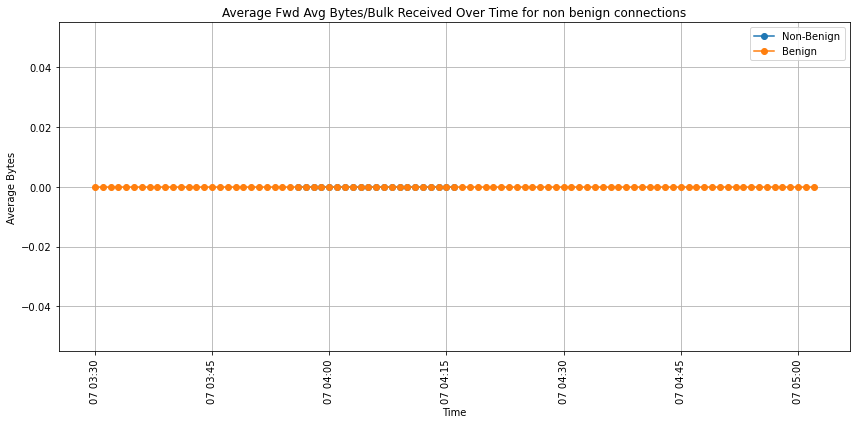

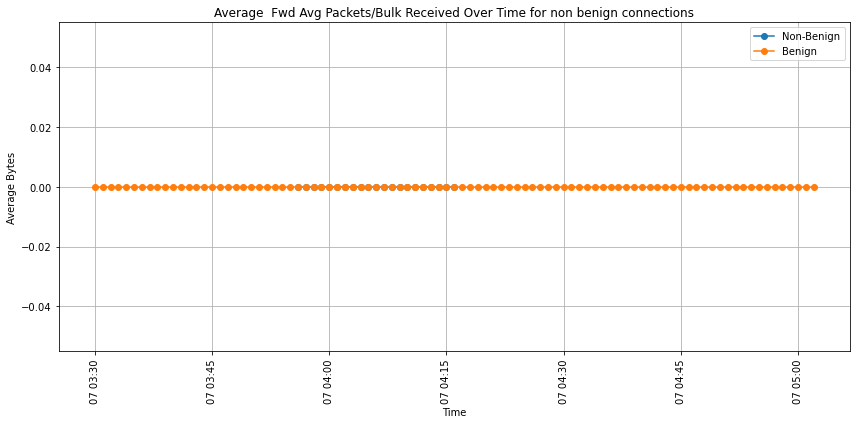

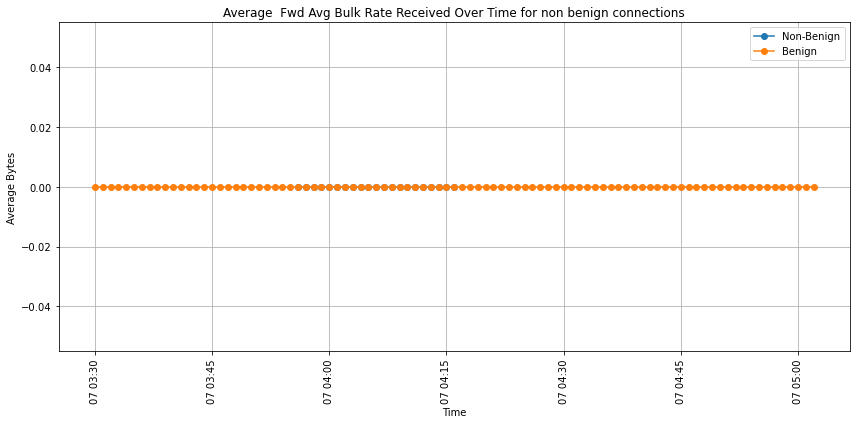

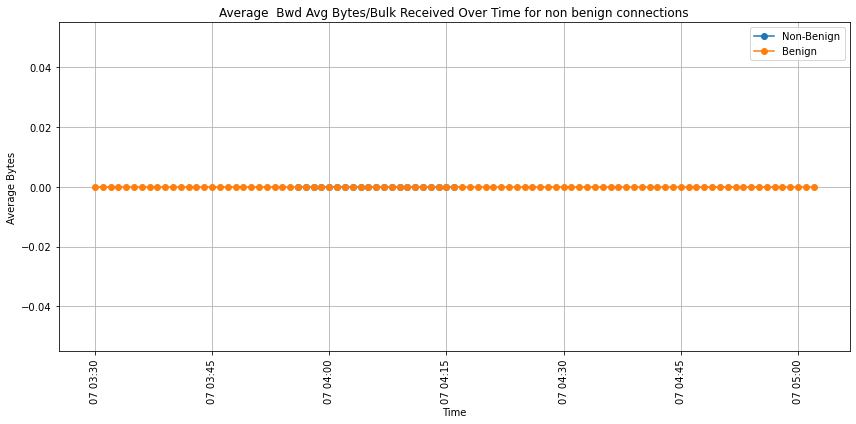

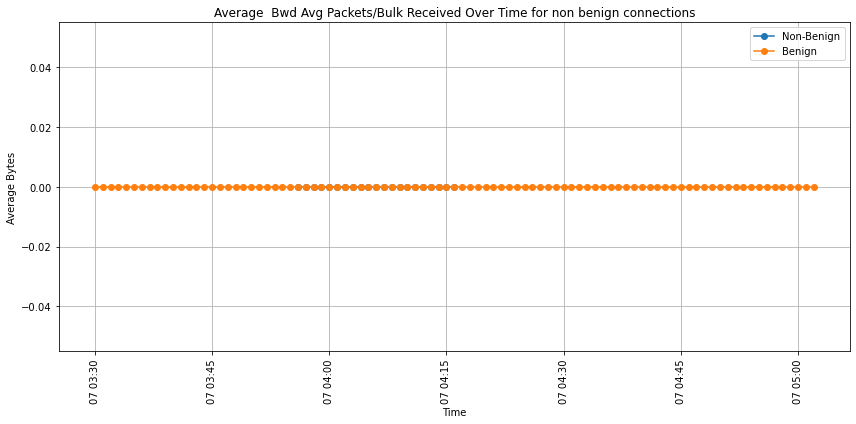

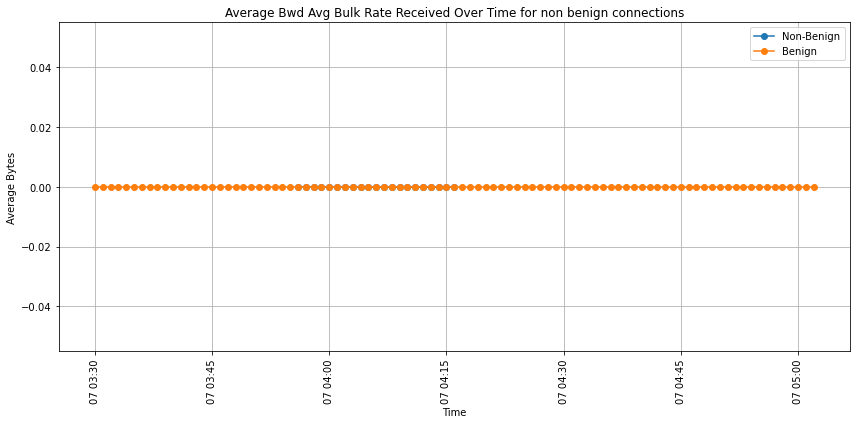

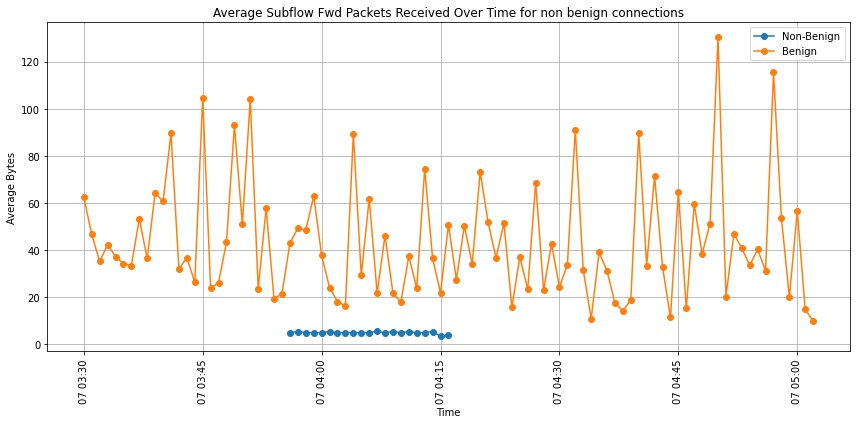

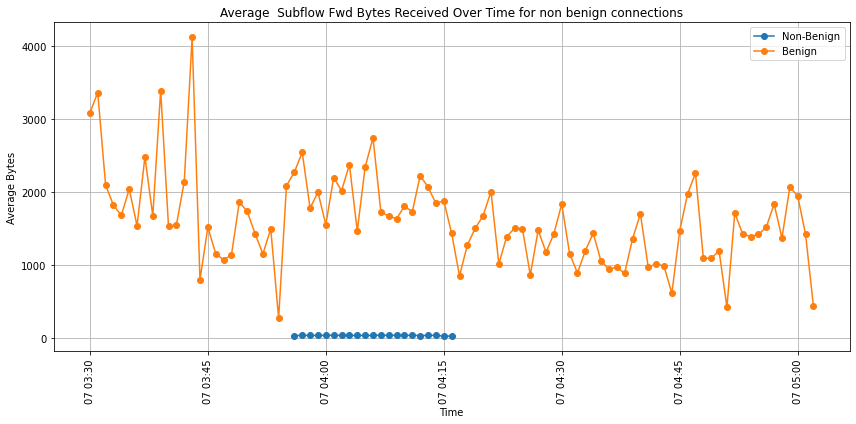

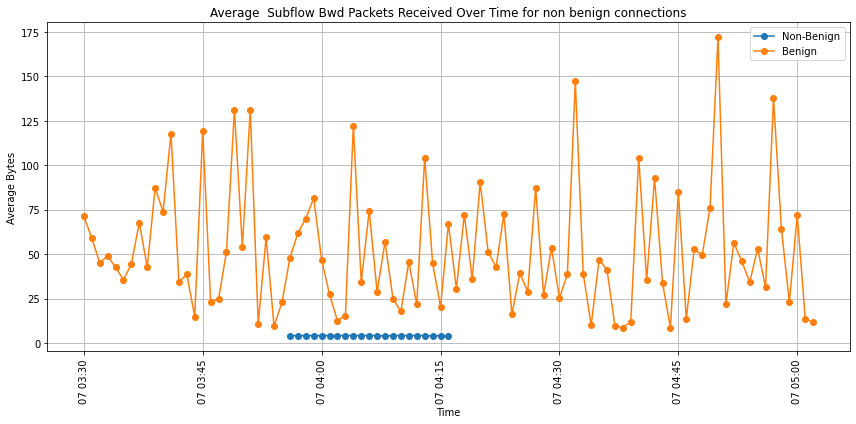

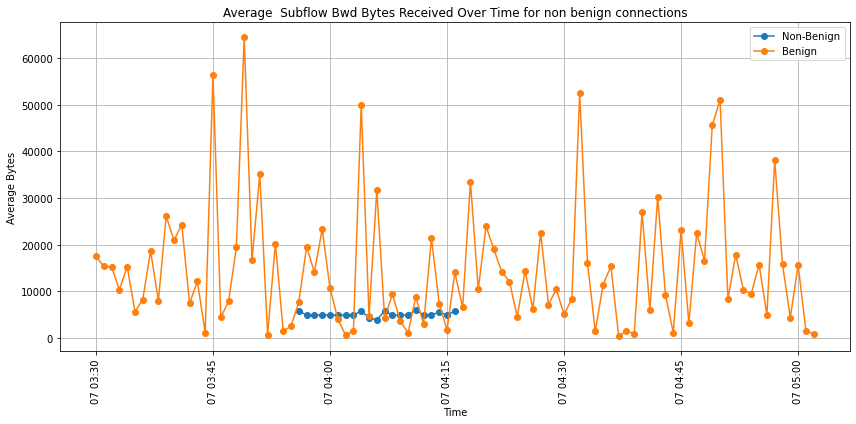

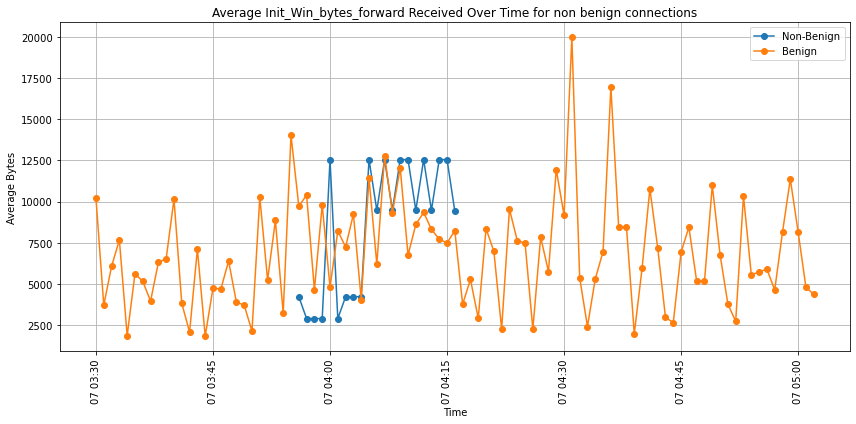

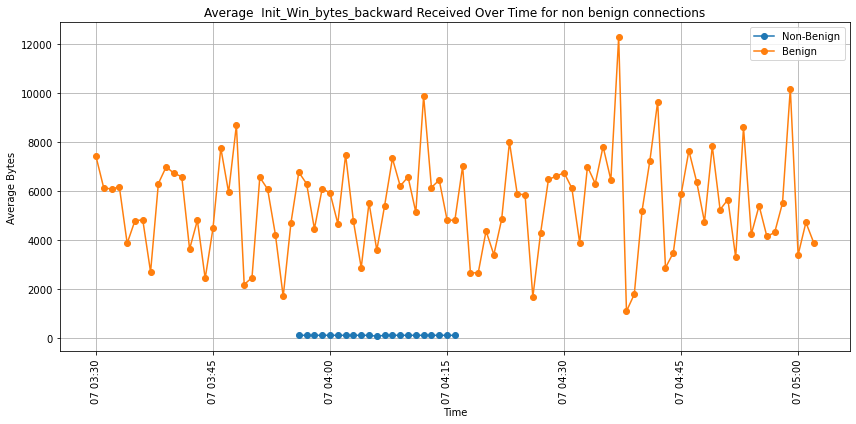

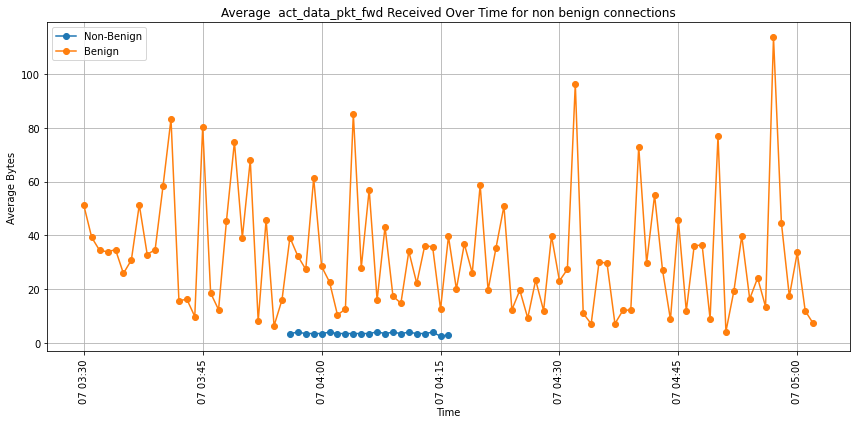

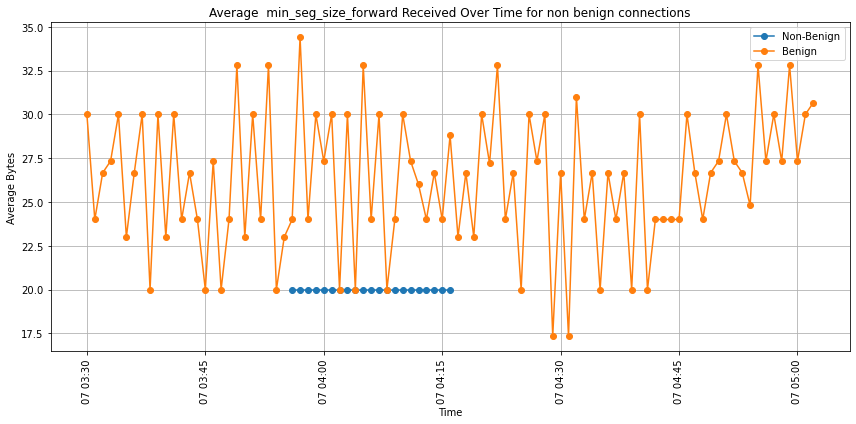

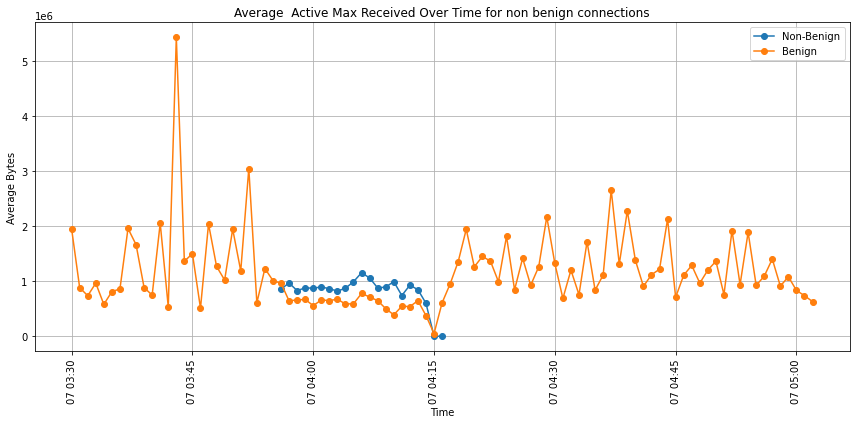

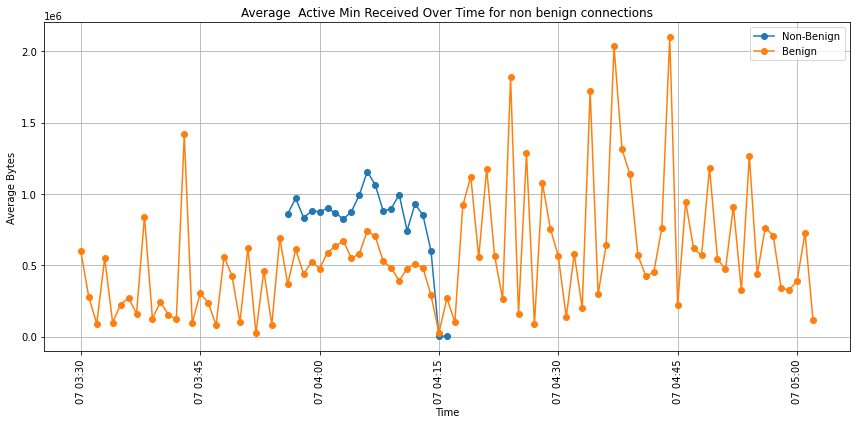

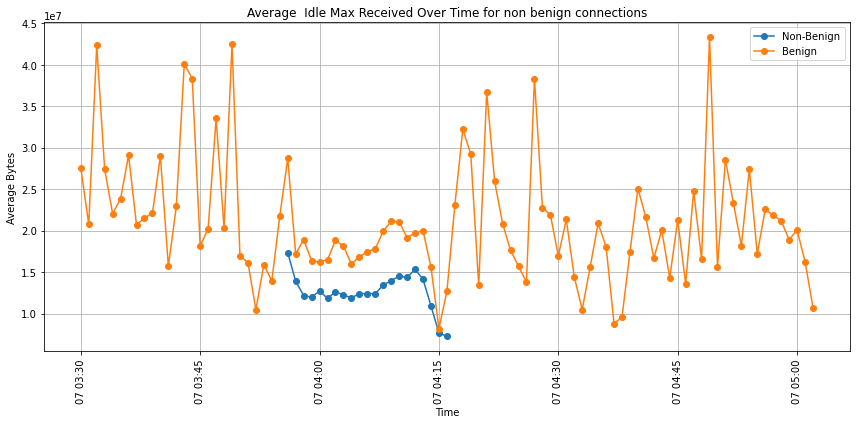

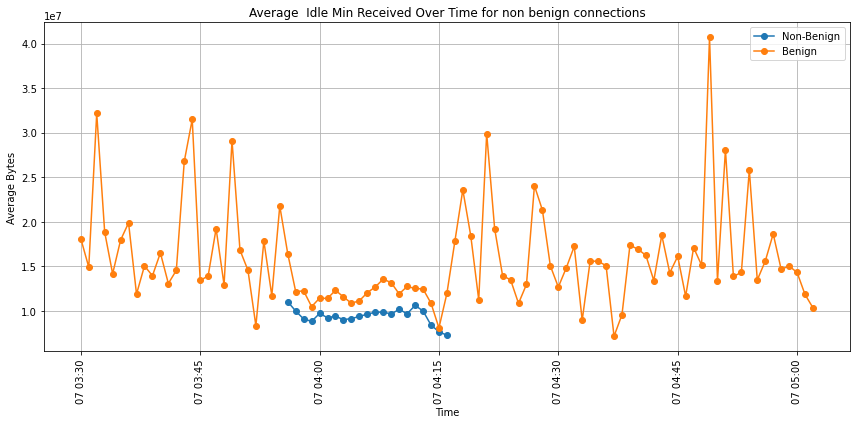

In [61]:
for i in discrete_vars_non_binary:
    if i !=' Timestamp':
        viz_variable(i)

# Data Cleaning and Transformation:
During this process, I will try to minimize a little the number of features, dropping constant and redundant features.

As well as highly correlated features.

## Deleting constant and redundant columns:

In [62]:
constant_columns=ddos_data.columns[ddos_data.nunique()==1]
constant_columns
len(constant_columns)

10

In [63]:
for column in constant_columns:
  print(f'The colonne {column} takes only one value:\n {ddos_data[column].value_counts()}\n')

The colonne  Bwd PSH Flags takes only one value:
 0    225745
Name:  Bwd PSH Flags, dtype: int64

The colonne  Fwd URG Flags takes only one value:
 0    225745
Name:  Fwd URG Flags, dtype: int64

The colonne  Bwd URG Flags takes only one value:
 0    225745
Name:  Bwd URG Flags, dtype: int64

The colonne  CWE Flag Count takes only one value:
 0    225745
Name:  CWE Flag Count, dtype: int64

The colonne Fwd Avg Bytes/Bulk takes only one value:
 0    225745
Name: Fwd Avg Bytes/Bulk, dtype: int64

The colonne  Fwd Avg Packets/Bulk takes only one value:
 0    225745
Name:  Fwd Avg Packets/Bulk, dtype: int64

The colonne  Fwd Avg Bulk Rate takes only one value:
 0    225745
Name:  Fwd Avg Bulk Rate, dtype: int64

The colonne  Bwd Avg Bytes/Bulk takes only one value:
 0    225745
Name:  Bwd Avg Bytes/Bulk, dtype: int64

The colonne  Bwd Avg Packets/Bulk takes only one value:
 0    225745
Name:  Bwd Avg Packets/Bulk, dtype: int64

The colonne Bwd Avg Bulk Rate takes only one value:
 0    2257

We're going to remove constant features,it's is important because they provide no useful information for predicting the target variable, contribute to computational inefficiency, and can potentially lead to model overfitting, thus hindering model interpretability and performance.

In [64]:
ddos_data[[ 'Flow ID',' Destination IP',' Source IP', ' Destination Port',' Source Port',' Protocol']]

,Flow ID,Destination IP,Source IP,Destination Port,Source Port,Protocol
0,192.168.10.5-104.16.207.165-54865-443-6,192.168.10.5,104.16.207.165,54865,443,6
1158,192.168.10.3-192.168.10.5-53-56771-17,192.168.10.3,192.168.10.5,53,56771,17
1157,192.168.10.3-192.168.10.5-53-55057-17,192.168.10.3,192.168.10.5,53,55057,17
1156,192.168.10.3-192.168.10.5-53-53400-17,192.168.10.3,192.168.10.5,53,53400,17
1155,192.168.10.3-192.168.10.5-53-62896-17,192.168.10.3,192.168.10.5,53,62896,17
...,...,...,...,...,...,...
225640,192.168.10.3-192.168.10.19-53-20516-17,192.168.10.3,192.168.10.19,53,20516,17
225641,192.168.10.3-192.168.10.19-53-21215-17,192.168.10.3,192.168.10.19,53,21215,17
225642,192.168.10.3-192.168.10.19-53-48588-17,192.168.10.3,192.168.10.19,53,48588,17
225664,192.168.10.19-62.161.94.230-54279-443-6,62.161.94.230,192.168.10.19,443,54279,6


It seems like the 'Flow ID' column contains concatenated information about source IP, destination IP, destination port, and protocol. We can drop it since it won't add much value.

In [65]:
are_equal = (ddos_data[' Fwd Header Length'] == ddos_data[' Fwd Header Length.1'])
all_equal = are_equal.all()
if all_equal:
    print("The two columns are the same.")
else:
    print("The two columns are not the same.")

The two columns are the same.


In [66]:
def dropping_const_and_red_columns(ddos_data):
    ddos_data.drop(['Flow ID',' Fwd Header Length.1'],axis=1,inplace=True)
    ddos_data.drop(columns=constant_columns,inplace=True)

In [67]:
dropping_const_and_red_columns(ddos_data)

## Label encoding for categorical features:

In [68]:
# Initialize LabelEncoder
label_encoder=LabelEncoder()
# Function to encode ' Label'
def encode_label_col(ddos_data):
    ddos_data[' Label']=label_encoder.fit_transform(ddos_data[' Label'])
# Function to encode IP addresses
def encoding_ip_srv_dst(ddos_data):
    all_ip=pd.concat([ddos_data[' Source IP'],ddos_data[' Destination IP']])
    label_encoder.fit(all_ip)
    ddos_data[' Source IP']=label_encoder.transform(ddos_data[' Source IP'])
    ddos_data[' Destination IP']=label_encoder.transform(ddos_data[' Destination IP'])

In [69]:
encode_label_col(ddos_data)
encoding_ip_srv_dst(ddos_data)

In [70]:
ddos_data

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,24,443,871,54865,6,2017-07-07 03:30:00,3,2,0,12,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
1158,871,56771,870,53,17,2017-07-07 03:30:00,59362,4,2,152,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
1157,871,55057,870,53,17,2017-07-07 03:30:00,61344,4,2,176,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
1156,871,53400,870,53,17,2017-07-07 03:30:00,238,2,2,82,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
1155,871,62896,870,53,17,2017-07-07 03:30:00,24052,2,2,124,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225640,867,20516,870,53,17,2017-07-07 05:02:00,254,2,2,70,...,40,0.0,0.0,0,0,0.0,0.0,0,0,0
225641,867,21215,870,53,17,2017-07-07 05:02:00,302,2,2,70,...,40,0.0,0.0,0,0,0.0,0.0,0,0,0
225642,867,48588,870,53,17,2017-07-07 05:02:00,273,2,2,70,...,32,0.0,0.0,0,0,0.0,0.0,0,0,0
225664,867,54279,2209,443,6,2017-07-07 05:02:00,11,2,0,12,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0


In [71]:
#I made this copy without the ' Timestamp' on which I will do a correlation analysis
ddos_data_cp=ddos_data.drop(' Timestamp',axis=1)

## Correlation analysis and feature selection:

In [72]:
ddos_data_cp.corr()

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
Source IP,1.000000,-0.364323,-0.010057,0.454587,0.298156,-0.040601,0.020113,0.038123,0.210294,-0.037069,...,0.289566,-0.022408,0.079552,0.013414,-0.037990,-0.084251,-0.067886,-0.090827,-0.062509,-0.752707
Source Port,-0.364323,1.000000,0.292387,-0.727093,0.193702,0.066677,0.046492,-0.005598,-0.376220,0.053109,...,0.051752,0.035426,0.015362,0.037363,0.034631,0.051217,0.040340,0.055066,0.037903,0.388721
Destination IP,-0.010057,0.292387,1.000000,-0.374056,0.003325,-0.045646,0.054167,0.011315,-0.209284,0.026897,...,0.166936,-0.036924,0.081243,0.006315,-0.050291,-0.111537,-0.082802,-0.118200,-0.085869,0.019534
Destination Port,0.454587,-0.727093,-0.374056,1.000000,-0.183045,0.107038,-0.044270,0.008321,0.553843,-0.066648,...,-0.074278,0.061313,-0.026592,0.043156,0.066356,0.132272,0.110687,0.144428,0.095687,-0.509798
Protocol,0.298156,0.193702,0.003325,-0.183045,1.000000,-0.194691,-0.077461,-0.052777,-0.107639,-0.060670,...,0.474116,-0.096252,-0.033096,-0.099233,-0.092237,-0.169636,-0.116058,-0.176677,-0.133858,-0.471904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Idle Mean,-0.084251,0.051217,-0.111537,0.132272,-0.169636,0.871855,0.110787,0.065554,0.261110,0.042256,...,-0.139772,0.595859,0.022025,0.531538,0.602021,1.000000,0.420170,0.952585,0.910822,0.087114
Idle Std,-0.067886,0.040340,-0.082802,0.110687,-0.116058,0.630604,0.056807,0.028627,0.216771,0.020081,...,-0.099363,-0.057820,-0.003866,-0.055222,-0.058847,0.420170,1.000000,0.676276,0.008218,0.078023
Idle Max,-0.090827,0.055066,-0.118200,0.144428,-0.176677,0.919199,0.109429,0.062932,0.284694,0.041055,...,-0.146873,0.464725,0.017842,0.413812,0.469089,0.952585,0.676276,1.000000,0.742109,0.096775
Idle Min,-0.062509,0.037903,-0.085869,0.095687,-0.133858,0.672003,0.094747,0.058056,0.188569,0.036789,...,-0.109090,0.682722,0.024496,0.609839,0.690201,0.910822,0.008218,0.742109,1.000000,0.061243


This is such an enormous correlation matrix, it will be hard from this to identify highly correlated features. 
**I identified a threshold (absolute correlation > 0.9) to identify highly correlated features.**

In [73]:
correlation_matrix = ddos_data_cp.corr()

# Get the highly correlated features (absolute correlation > 0.5)
highly_correlated = correlation_matrix.abs() > 0.9

# Extract the indices of highly correlated features
correlated_features = [(feature1, feature2) for feature1 in correlation_matrix.columns 
                       for feature2 in correlation_matrix.columns 
                       if highly_correlated.loc[feature1, feature2] and feature1 != feature2]

# Print the highly correlated feature pairs
printed_pairs = set()
for feature1, feature2 in correlated_features:
    if (feature2, feature1) not in printed_pairs:  # Check if the pair has already been printed
        print(f"{feature1} and {feature2} are highly correlated: {correlation_matrix.loc[feature1, feature2]}")
        printed_pairs.add((feature1, feature2)) 


 Flow Duration and  Flow IAT Max are highly correlated: 0.9202572641153459
 Flow Duration and Fwd IAT Total are highly correlated: 0.9970539718288864
 Flow Duration and  Fwd IAT Max are highly correlated: 0.9179458157780408
 Flow Duration and  Idle Max are highly correlated: 0.9191990945207641
 Total Fwd Packets and  Total Backward Packets are highly correlated: 0.9567137090971858
 Total Fwd Packets and  Total Length of Bwd Packets are highly correlated: 0.938469804026319
 Total Fwd Packets and  Fwd Header Length are highly correlated: 0.9684337767323997
 Total Fwd Packets and  Bwd Header Length are highly correlated: 0.9287367502718795
 Total Fwd Packets and Subflow Fwd Packets are highly correlated: 1.0
 Total Fwd Packets and  Subflow Bwd Packets are highly correlated: 0.9567137090971858
 Total Fwd Packets and  Subflow Bwd Bytes are highly correlated: 0.938469804026319
 Total Backward Packets and  Total Length of Bwd Packets are highly correlated: 0.9704220020383922
 Total Backward P

**Feature Selection:**
Next, I proceeded to drop highly correlated columns to address multicollinearity issues and reduce redundancy in the dataset. I performed this step iteratively, considering different sets of features and their correlations with the target variable ('Label'). By carefully evaluating the correlation between each feature and the target variable, I aimed to retain the most informative and independent features while eliminating those that might introduce noise or redundancy into the model. This iterative process helped me refine the feature set and improve the predictive performance of the model.

In [74]:
corr_set1=[' Flow Duration',' Flow IAT Max','Fwd IAT Total',' Fwd IAT Max',' Idle Max']
# Calculate the correlation between the features and the 'Label' column
correlation_set1 = ddos_data[corr_set1 + [' Label']].corr()

# Get the correlation of each feature with the 'Label' column
label_correlation_set1 = correlation_set1[' Label'].drop(' Label')

print(label_correlation_set1)

 Flow Duration    0.025923
 Flow IAT Max     0.100654
Fwd IAT Total     0.040565
 Fwd IAT Max      0.105457
 Idle Max         0.096775
Name:  Label, dtype: float64


In [75]:
ddos_data.drop(columns=[' Flow Duration',' Flow IAT Max','Fwd IAT Total',' Idle Max'],inplace=True)

In [76]:
corr_set2=[' Total Fwd Packets',' Total Backward Packets',' Total Length of Bwd Packets',' Fwd Header Length',' Bwd Header Length','Subflow Fwd Packets',' Subflow Bwd Packets',' Subflow Bwd Bytes']
# Calculate the correlation between the features and the 'Label' column

correlation_set2 = ddos_data[corr_set2 + [' Label']].corr()

# Get the correlation of each feature with the 'Label' column
label_correlation_set2 = correlation_set2[' Label'].drop(' Label')

print(label_correlation_set2)

 Total Fwd Packets             -0.029870
 Total Backward Packets        -0.069290
 Total Length of Bwd Packets    0.041244
 Fwd Header Length             -0.043942
 Bwd Header Length             -0.076183
Subflow Fwd Packets            -0.029870
 Subflow Bwd Packets           -0.069290
 Subflow Bwd Bytes              0.041244
Name:  Label, dtype: float64


In [77]:
ddos_data.drop(columns=[' Total Fwd Packets',' Total Backward Packets',' Total Length of Bwd Packets',' Fwd Header Length','Subflow Fwd Packets',' Subflow Bwd Packets',' Subflow Bwd Bytes'],inplace=True)


Total Length of Fwd Packets and  Subflow Fwd Bytes are highly correlated: 1.0,

Fwd Packet Length Mean and  Avg Fwd Segment Size are highly correlated: 1.0

Total Length of Bwd Packets and  Subflow Bwd Bytes are highly correlated: 1.0

**We can keep only one of these features**

In [78]:
ddos_data.drop(['Fwd PSH Flags',' RST Flag Count'],axis=1,inplace=True)

In [79]:
ddos_data.drop([' Subflow Fwd Bytes',' Fwd Packet Length Mean'],axis=1,inplace=True)

In [80]:
corr_set3=[' Fwd Packet Length Max',' Fwd Packet Length Std',' Avg Fwd Segment Size']

correlation_set3 = ddos_data[corr_set3 + [' Label']].corr()

# Get the correlation of each feature with the 'Label' column
label_correlation_set3 = correlation_set3[' Label'].drop(' Label')

print(label_correlation_set3)

 Fwd Packet Length Max   -0.321529
 Fwd Packet Length Std   -0.300271
 Avg Fwd Segment Size    -0.356895
Name:  Label, dtype: float64


In [81]:
ddos_data.drop([' Fwd Packet Length Max',' Fwd Packet Length Std'],axis=1,inplace=True)

In [82]:
corr_set4=['Bwd Packet Length Max',' Bwd Packet Length Mean',' Bwd Packet Length Std',' Avg Bwd Segment Size']
correlation_set4 = ddos_data[corr_set4 + [' Label']].corr()

# Get the correlation of each feature with the 'Label' column
label_correlation_set4 = correlation_set4[' Label'].drop(' Label')

print(label_correlation_set4)

Bwd Packet Length Max      0.577323
 Bwd Packet Length Mean    0.603299
 Bwd Packet Length Std     0.576155
 Avg Bwd Segment Size      0.603299
Name:  Label, dtype: float64


In [83]:
ddos_data.drop(['Bwd Packet Length Max',' Bwd Packet Length Mean',' Bwd Packet Length Std'],axis=1,inplace=True)

In [84]:
corr_set5=[' Flow IAT Mean',' Flow IAT Std',' Fwd IAT Mean',' Fwd IAT Std',' Fwd IAT Max','Idle Mean',' Fwd IAT Min',' Bwd IAT Min',' Bwd IAT Max']
correlation_set5 = ddos_data[corr_set5 + [' Label']].corr()

# Get the correlation of each feature with the 'Label' column
label_correlation_set5 = correlation_set5[' Label'].drop(' Label')

print(label_correlation_set5)

 Flow IAT Mean    0.127503
 Flow IAT Std     0.129630
 Fwd IAT Mean     0.022030
 Fwd IAT Std      0.099651
 Fwd IAT Max      0.105457
Idle Mean         0.087114
 Fwd IAT Min     -0.061743
 Bwd IAT Min     -0.064277
 Bwd IAT Max     -0.292054
Name:  Label, dtype: float64


In [85]:
ddos_data.drop([' Flow IAT Mean',' Flow IAT Std',' Fwd IAT Mean',' Fwd IAT Std',' Fwd IAT Max','Idle Mean',' Fwd IAT Min',' Bwd IAT Min'],axis=1,inplace=True)

In [86]:
corr_set6=[' Bwd IAT Std',' Bwd IAT Max',' Max Packet Length',' Packet Length Mean',' Packet Length Std',' Packet Length Variance',' Average Packet Size']
correlation_set6 = ddos_data[corr_set6 + [' Label']].corr()

# Get the correlation of each feature with the 'Label' column
label_correlation_set6 = correlation_set6[' Label'].drop(' Label')

print(label_correlation_set6)

 Bwd IAT Std              -0.290896
 Bwd IAT Max              -0.292054
 Max Packet Length         0.414399
 Packet Length Mean        0.454283
 Packet Length Std         0.443749
 Packet Length Variance    0.408089
 Average Packet Size       0.453472
Name:  Label, dtype: float64


In [87]:
ddos_data.drop(columns=[' Bwd IAT Std',' Bwd IAT Max',' Max Packet Length',' Packet Length Std',' Packet Length Variance',' Average Packet Size'],axis=1,inplace=True)

In [88]:
corr_set7=['Active Mean',' Active Max',' Active Min']
correlation_set7 = ddos_data[corr_set7 + [' Label']].corr()

# Get the correlation of each feature with the 'Label' column
label_correlation_set7 = correlation_set7[' Label'].drop(' Label')

print(label_correlation_set7)

Active Mean    0.022905
 Active Max   -0.009271
 Active Min    0.033821
Name:  Label, dtype: float64


In [89]:
ddos_data.drop(columns=['Active Mean',' Active Max'],inplace=True)

In [90]:
ddos_data.corr()

KeyboardInterrupt: 

In [ ]:
# Compute the correlation matrix
correlation_matrix = ddos_data_cp.corr()

# Select the correlation values of the 'Label' column
label_correlation = correlation_matrix[' Label']

# Print the correlation values
print(label_correlation)

## Setting ` Timestamp` as an index
Since we will be working on a Time series model, the ` Timestamp` column won't be considered as a feature but an index.

In [ ]:
def setting_time_as_an_index(ddos_data):
    ddos_data.set_index(' Timestamp', inplace=True)

In [ ]:
setting_time_as_an_index(ddos_data)

In [ ]:
ddos_data.info()

In [ ]:
non_binary_columns=ddos_data.columns[ddos_data.nunique()>2]

## Scaling numerical data:

In [ ]:
scaler=StandardScaler()
def scale_num_features(ddos_data):
    ddos_data[non_binary_columns]=scaler.fit_transform(ddos_data[non_binary_columns])

In [ ]:
is_infinite = np.any(np.isinf(ddos_data[non_binary_columns]), axis=0)
is_large = np.any(np.abs(ddos_data[non_binary_columns]) > np.finfo(np.float64).max, axis=0)

In [ ]:
columns_with_issues = non_binary_columns[is_infinite]
print("Columns with Infinite or Large Values:", columns_with_issues)

**We can drop them**

In [ ]:
ddos_data.drop(columns=['Flow Bytes/s',' Flow Packets/s'], inplace=True)

In [ ]:
non_binary_columns=ddos_data.columns[ddos_data.nunique()>2]

In [ ]:
scale_num_features(ddos_data)

In [ ]:
# final columns that will be used for training
final_columns=ddos_data.columns

## Preparing the data for the time series model:
During this step, I'm setting up the data for training the model, specifically for a time series analysis task. 
* We initialize two empty lists `trainX` and `trainY` to store the input sequences and corresponding target values for our model training.
* `n_future = 1`: This variable represents how many time steps in the future we aim to predict.
* `n_past = 10`: This variable denotes the number of past time steps our model will utilize to make predictions about the future.
* For Loop:
   * We slice the DataFrame to extract the past `n_past` rows as input features  (trainX), representing the historical data that our model will use for prediction.
   * We select the next row after `n_future` time steps as the target variable (trainY), which represents the label or value to be predicted by our model.

In [ ]:
trainX=[]
trainY=[]
n_future=1
n_past=10
for i in range(n_past,len(ddos_data)-n_future+1):
    trainX.append(ddos_data.iloc[i-n_past:i, :])
    trainY.append(ddos_data.iloc[i+n_future-1:i+n_future][' Label'])
trainX, trainY=np.array(trainX), np.array(trainY)

In [ ]:
print(f'trainX shape=={trainX.shape}')
print(f'trainY shape=={trainY.shape}')

The shapes of our training data arrays are as follows:
`trainX` has a shape of **(225735, 10, 34)**, indicating that we have **225,735 samples, each consisting of a sequence of 10 time steps, with 34 features for each time step. For each sample, the model will receive the past 10 observations, each containing information about various features.**

On the other hand, `trainY` has a shape of **(225735, 1)**, meaning that for each of these samples, **the model will aim to predict a single binary outcome: whether the subsequent observation represents a DDOS attack or not. This setup allows the model to learn patterns in the historical data to make predictions about future DDOS attacks.**

# Building the LSTM Model, Training and Evaluation:

## Model Architecture:

In [ ]:
model=Sequential([
    LSTM(units=128, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])),
    LSTM(units=64, return_sequences=True),
    LSTM(units=32, return_sequences=False),
    Dropout(0.01),
    Dense(units=1, activation='sigmoid') 
])
model.compile(optimizer=Adam(learning_rate=1e-4),loss=BinaryCrossentropy(),metrics=['accuracy'])
model.summary()

## Training the model:

In [ ]:
history_log=model.fit(trainX, trainY, epochs=100, batch_size=1024, validation_split=0.2,verbose=2, shuffle=False)

## Plotting loss per epoch:

In [ ]:
loss = history_log.history['loss']
val_loss = history_log.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Loss v/s No. of epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The training loss starts high and steadily decreases throughout the epochs, indicating that the model is learning.
The validation loss also decreases, but to a lesser extent, suggesting that the model generalizes well to unseen data.

 ## Plotting the accuracy per epoch:

In [ ]:
accuracy = history_log.history['accuracy']
val_accuracy = history_log.history['val_accuracy']
plt.plot(epochs, accuracy , 'g', label = 'Training accuracy')
plt.plot(epochs, val_accuracy , 'r', label = 'Validation accuracy')
plt.title('Accuracy Scores v/s Number of Epochs')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()

The learning accuracy starts moderately and increases rapidly to reach near-perfect accuracy.
The validation accuracy follows a similar trend, although it slightly lags behind the training accuracy, which is expected.


## Test set and evaluation:

In [ ]:
ddos_data_test = pd.read_csv('C:/Users/NGESSI/Documents/DDoS Prediction/v2/data_test/ddos_data_test.csv')
ddos_data_test = ddos_data_test[train_columns]
print(ddos_data_test.shape)

In [ ]:
visualize_labels_distribution(ddos_data_test)

**This test set contains various types of attacks**

### Performing same preprocessing steps as training set:

In [ ]:
label_encoder=LabelEncoder()
def Encode_Label_Column_1(ddos_data):
    label_mapping = {'BENIGN': 0, 'Syn': 1, 'TFTP': 1, 'DrDoS_LDAP': 1, 'DrDoS_UDP': 1, 'UDP-lag': 1,
                 'DrDoS_SNMP': 1, 'DrDoS_SSDP': 1, 'DrDoS_NetBIOS': 1, 'DrDoS_MSSQL': 1,
                 'DrDoS_DNS': 1, 'DrDoS_NTP': 1, 'WebDDoS': 1}
    #ddos_data[' Label']=label_encoder.fit_transform(ddos_data[' Label'])
    ddos_data[' Label'] = ddos_data[' Label'].map(label_mapping)

In [ ]:
def data_preprocessing(ddos_data_test):
    normalize_timestamp(ddos_data_test)
    dropping_const_and_red_columns(ddos_data_test)
    Encode_Label_Column_1(ddos_data_test)
    encoding_ip_srv_dst(ddos_data_test)
    setting_time_as_an_index(ddos_data_test)
    ddos_data_test=ddos_data_test[final_columns]
    print('data preprocessing completed \n')
    return (ddos_data_test)

ddos_data_test=data_preprocessing(ddos_data_test)
ddos_data_test.shape

In [ ]:
non_binary_columns=ddos_data_test.columns[ddos_data_test.nunique()>2]
scale_num_features(ddos_data_test)
testX=[]
testY=[]
n_future=1
n_past=10
for i in range(n_past,len(ddos_data_test)-n_future+1):
    testX.append(ddos_data_test.iloc[i-n_past:i, :])
    testY.append(ddos_data_test.iloc[i+n_future-1:i+n_future][' Label'])
testX, testY=np.array(testX), np.array(testY)

In [ ]:
non_binary_columns

In [ ]:
# Run predictions on the test set
y_pred = model.predict(testX)

# If your model is for binary classification with a sigmoid activation
# You can threshold the predictions to get binary results
binary_predictions = (y_pred > 0.5).astype(int)

In [ ]:
y_pred

In [ ]:
accuracy = accuracy_score(testY, binary_predictions)
precision = precision_score(testY, binary_predictions)
recall = recall_score(testY, binary_predictions)
f1 = f1_score(testY, binary_predictions)


print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

Overall, it seems like the model achieved good performance with high accuracy, precision, recall, and F1 score on the test set, **indicating that it's able to effectively detect various types of attacks.**

In [ ]:
model.save('ddos.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('ddos.h5')

# Model deployment

In [ ]:
import tkinter as tk
from tkinter import filedialog
from tkinter.scrolledtext import ScrolledText
import pandas as pd
import os

def open_csv_file():
    file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
    if file_path:
        file_name = os.path.basename(file_path)
        df = pd.read_csv(file_path)
        event_log.insert(tk.END, f"csv file opened : {file_name}\n")

def start_model_execution():
    event_log.insert(tk.END, "execution starting..\n")

def stop_model_execution():
    event_log.insert(tk.END, "Arrêt de l'exécution du modèle...\n")

root = tk.Tk()
root.title("NETAD 1.0")

file_start_frame = tk.Frame(root)
file_start_frame.pack(padx=30, pady=(10, 0), fill=tk.X)



open_button = tk.Button(file_start_frame, text="Choose data flow", command=open_csv_file)
open_button.grid(row=0, column=1, padx=(0, 5))

start_button = tk.Button(file_start_frame, text="Start prediction", command=start_model_execution)
start_button.grid(row=0, column=2, padx=(0, 5))

stop_button = tk.Button(file_start_frame, text="Stop prediction", command=stop_model_execution)
stop_button.grid(row=0, column=3, padx=(0, 5))

event_frame = tk.Frame(root)
event_frame.pack(padx=10, pady=(0, 10), fill=tk.BOTH, expand=True)


event_log = ScrolledText(event_frame, width=60, height=10)
event_log.pack(padx=5, pady=5, fill=tk.BOTH, expand=True)

root.mainloop()
